<a href="https://colab.research.google.com/github/ChaithraKNagaraju/ecg-classification/blob/master/Arrhythmia_Classification_Full_and_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single-Lead ECG Arrhythmia Classification**


---

By- Md Rabiul Islam



## **a. Summary, At a Glance**


*   **Task:** Arrhythmia Classification, 5 classes
*   **Dataset:** MIT-BIH ECG dataset, Dataset website: [Here](https://physionet.org/content/mitdb/1.0.0/)
*   **Model:** CNN_LSTM with Attention
*   **Made By:** Md Rabiul Islam, PhD Student, Texas A&M University. [Personal Website](https://sites.google.com/view/rabiuleeekuet/home). [Google Scholar](https://scholar.google.com/citations?user=GfveUqIAAAAJ&hl=en). Email: rabiul.kuet.bd@gmail.com.
*   **Supervised By:** Prof. Dr. Erchin Serpedin. (Collaboration: Prof. Dr. Khalid Qaraqe, Assoc. Prof. Dr. Marwa Qaraqe)
*   **Date:** November 2022 - January 2023

## **b. Information about Dataset:**


The dataset can be downloaded from the original [website](https://physionet.org/content/mitdb/1.0.0/) or by clicking the [link](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip) directly. The overall information about the dataset is given [here](https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm).
1. The MIT-BIH dataset contains **48 readings**.
2. Number of **patients = 47** (25 Men, 22 Women). Only 1 patient has 2 readings. Rest 1 readings/patients.
3. Each reading contains a. ECG signals b. Annotations
4. ECG signals length = **30 Minutes** (or slightly over). Sampling Frequency = **360 Hz**.
5. Each reading contains **2 Lead ECG** signals that are Modified Limb Lead II and Modified Lead V1 (Occationally V2, V5, V4 just only once). Simply, Two Leads: **MLII, V1**.
6. Annotation is given for each beat. Although 20 types of beats are annotated in dataset. We consider only **15 types** of beats grouped in **5 classes** followed by the recommendation of **AAMI**.
* N - Normal
* S - Supraventricular premature beat
* V - Premature ventricular contraction
* F - Fusion of ventricular and normal beat
* Q - Unclassifiable / Unknown beat

### **Additional Dataset Information:**
The source of the ECGs included in the MIT-BIH Arrhythmia Database is a set of over **4000 long-term Holter recordings** that were obtained by the **Beth Israel Hospital** Arrhythmia Laboratory between **1975 and 1979**. Approximately **60%** of these recordings were obtained from **inpatients**. The subjects were 25 men aged 32 to 89 years, and 22 women aged 23 to 89 years

# **Main Parts of the Study:**

1.   **Part A: Installing Packages and Basic Visualization of ECG**
2.   **Part B: Denoising, R-Peak Detection, Segmentation**
3.   **Part C: Dataset Loading**
4.   **Part D: Train-Test Splitting and Class Balancing**
5.   **Part E: Model Building and Training**
6.   **Part F: Results**

# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**

In [49]:
# wfdb is not normally installed in Colab
!pip install wfdb

In [50]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

## **A2: Basic Visualization of ECG**
Basic code for loading (reading), plotting and playing with ECG signals

### **a. Getting Recordings' IDs**
The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings.

In [51]:
import pandas as pd

# ✅ Path to the RECORDS file (adjust if needed)
DATA_ROOT = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/RECORDS"

# Each line contains one record ID
patient_ids = pd.read_csv(DATA_ROOT, header=None)[0].tolist()

print("First 10 records:", patient_ids[:10])
print("Total records:", len(patient_ids))

First 10 records: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Total records: 48


In [52]:
import wfdb

# MIT-BIH has 48 records: 100–234 (not continuous)
record_ids = ["100","101","102","103","104","105","106","107","108","109",
              "111","112","113","114","115","116","118","119","121","122",
              "123","124","200","201","202","203","205","207","208","209",
              "210","212","213","214","215","217","219","220","221","222",
              "223","228","230","231","232","233","234"]

# Test reading one record
signals, info = wfdb.rdsamp("100", pn_dir="mitdb")
annotation = wfdb.rdann("100", "atr", pn_dir="mitdb")

print("Signal shape:", signals.shape)
print("Sampling frequency:", info['fs'])
print("Number of beats:", len(annotation.sample))

Signal shape: (650000, 2)
Sampling frequency: 360
Number of beats: 2274


In [53]:
import wfdb
import os

DATA_ROOT = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"

# Example: record 100
record_id = "100"
record_path = os.path.join(DATA_ROOT, record_id)

# Load signal and annotation
signals, info = wfdb.rdsamp(record_path)
annotation = wfdb.rdann(record_path, "atr")

print("Signal shape:", signals.shape)
print("Annotation symbols:", set(annotation.symbol))

Signal shape: (650000, 2)
Annotation symbols: {'V', 'N', 'A', '+'}


In [54]:
import pandas as pd
import numpy as np

# Path to dataset folder
DATA_ROOT = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"

# Path to RECORDS file
record_file = f"{DATA_ROOT}/RECORDS"

# Load record IDs
patient_ids = pd.read_csv(record_file, header=None)[0].astype(int).to_numpy()

print(patient_ids)   # default numpy format

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


### **b. 1 Patient ECG loading and plotting**
Extracting 2 leads ECG signals of a patient (for example: 100), and saving in two lists.

In [55]:
#Extracting just 1 patient ECG signal and info
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


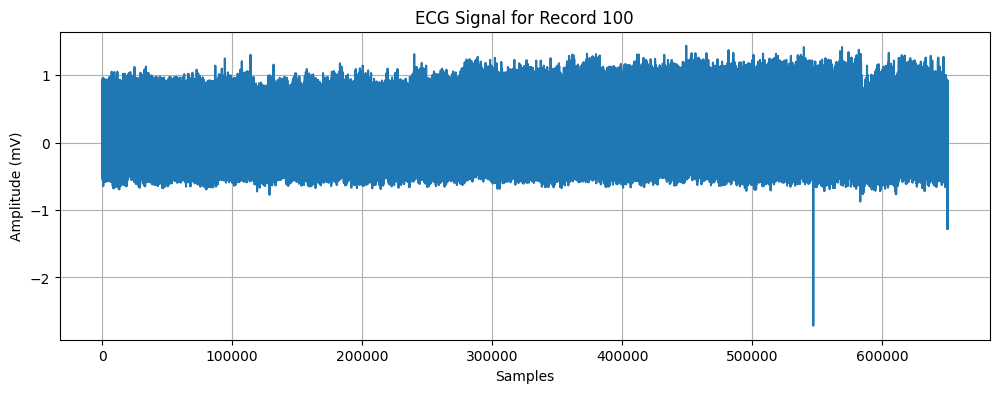

In [56]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
print(info)
import matplotlib.pyplot as plt
import numpy as np

# Suppose lead0[100] contains one lead of ECG
plt.figure(figsize=(12, 4))
plt.plot(lead0[100])

plt.title("ECG Signal for Record 100")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

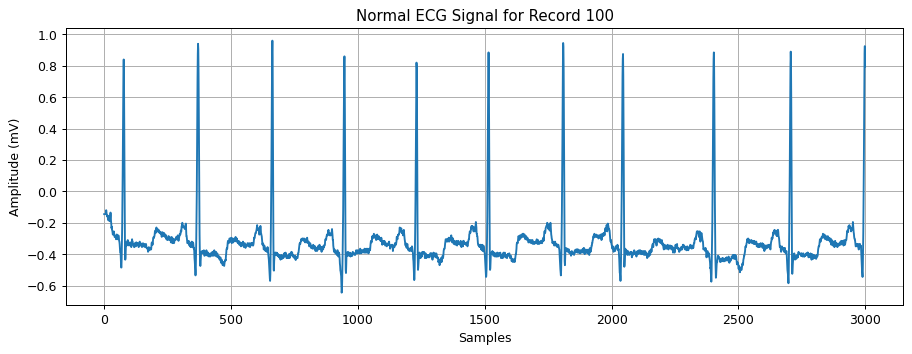

In [57]:
# ECG signal per second
a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("Normal ECG Signal for Record 100")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

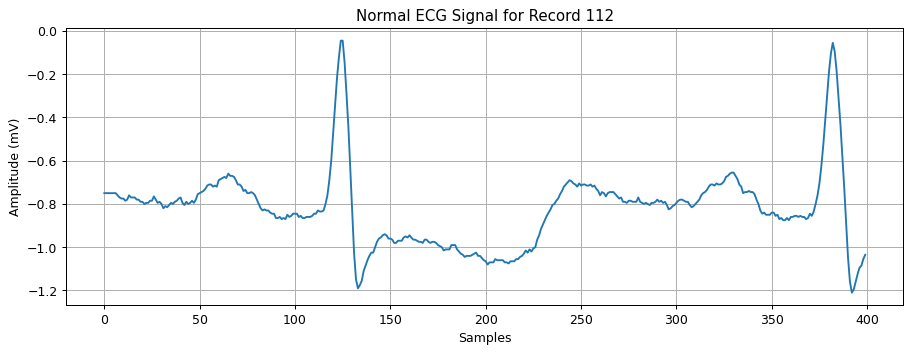

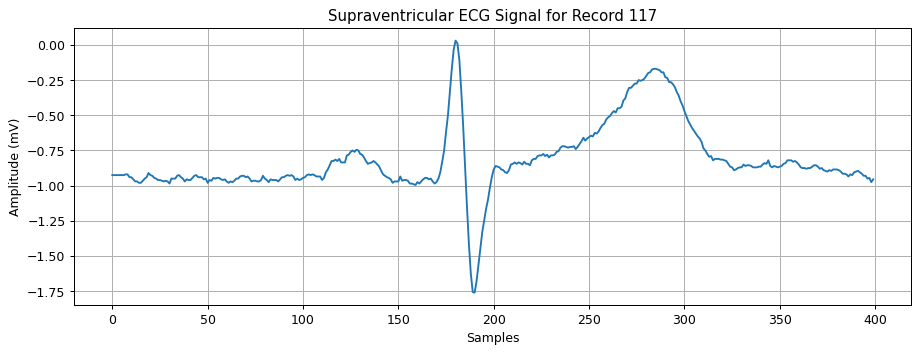

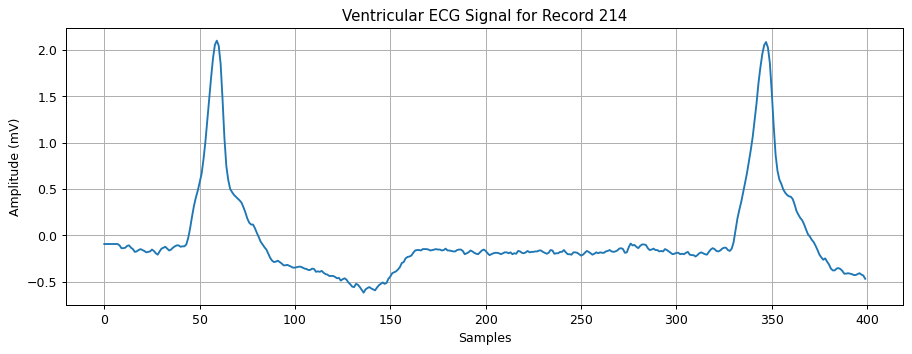

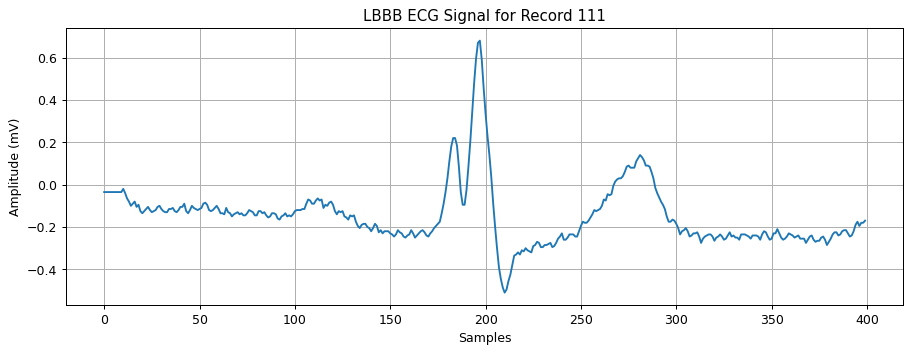

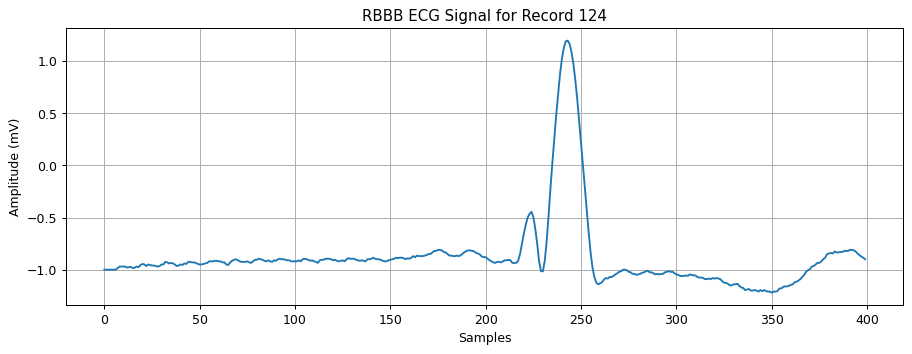

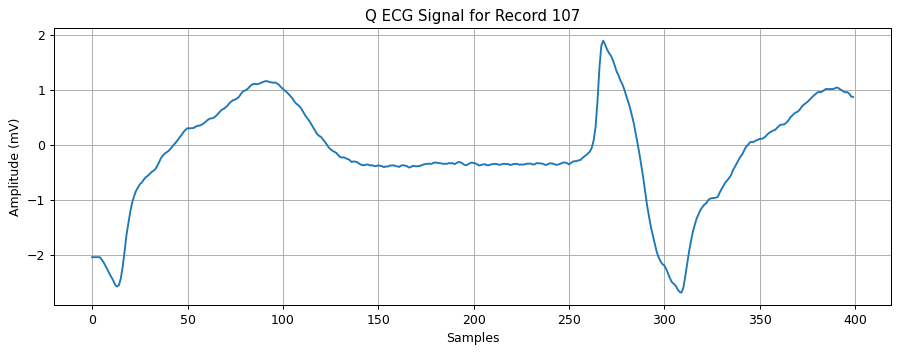

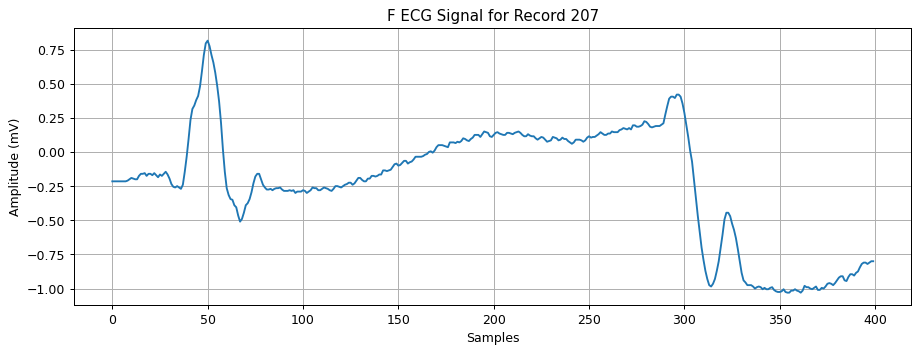

In [58]:
patient_id = 112
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[112] = signals[:, 0]
lead1[112] = signals[:, 1]
a = lead0[112][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("Normal ECG Signal for Record 112")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 117
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[117] = signals[:, 0]
lead1[117] = signals[:, 1]
a = lead0[117][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("Supraventricular ECG Signal for Record 117")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 214
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[214] = signals[:, 0]
lead1[214] = signals[:, 1]
a = lead0[214][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("Ventricular ECG Signal for Record 214")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 111
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[111] = signals[:, 0]
lead1[111] = signals[:, 1]
a = lead0[111][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("LBBB ECG Signal for Record 111")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 124
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[124] = signals[:, 0]
lead1[124] = signals[:, 1]
a = lead0[124][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("RBBB ECG Signal for Record 124")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 107
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[107] = signals[:, 0]
lead1[107] = signals[:, 1]
a = lead0[107][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("Q ECG Signal for Record 107")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

patient_id = 207
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_id)))
lead0[207] = signals[:, 0]
lead1[207] = signals[:, 1]
a = lead0[207][0:400]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)
plt.title("F ECG Signal for Record 207")
plt.xlabel("Samples")       # Or "Time (s)" after conversion
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

### **c. All patients' ECG loading**

In [59]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [60]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [61]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

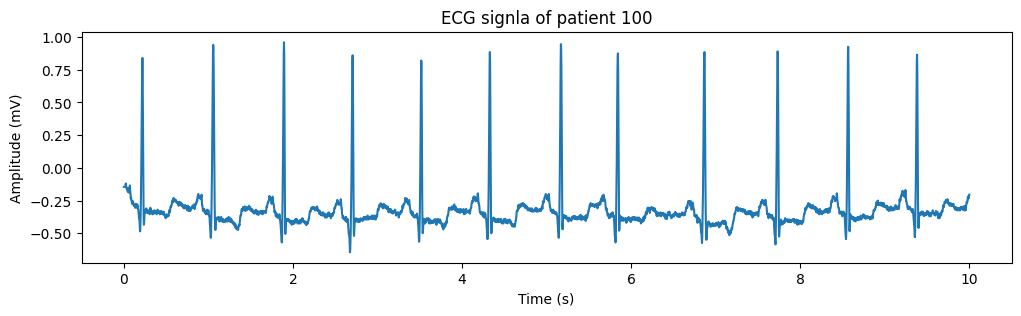

In [62]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

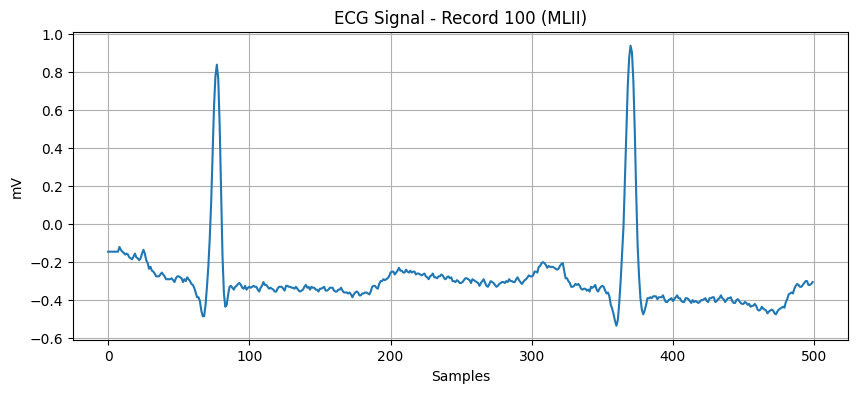

In [63]:
import wfdb
import matplotlib.pyplot as plt

# Define your dataset path
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Load record 100 (MLII lead)
record = wfdb.rdrecord(project_path + "100", channel_names=['MLII'])

# Flatten the signal for plotting
data = record.p_signal.flatten()

# Plot first 500 samples
plt.figure(figsize=(10,4))
plt.plot(data[0:500])
plt.title("ECG Signal - Record 100 (MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

In [64]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

In [65]:
def get_ecg_info(record_id):
    record_path = f"/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/{record_id}"
    signals, info = wfdb.rdsamp(record_path)
    annotation = wfdb.rdann(record_path, "atr")
    return signals, info, annotation

# Usage
signals, info, ann = get_ecg_info(patient_ids[0])
print(info)

{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


# **Part B: Denoising, R-Peak Detection, Segmentation**

### **B1: Denoising**
Noise removing by using Discrete Wavelet Transform (DCT)

In [66]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

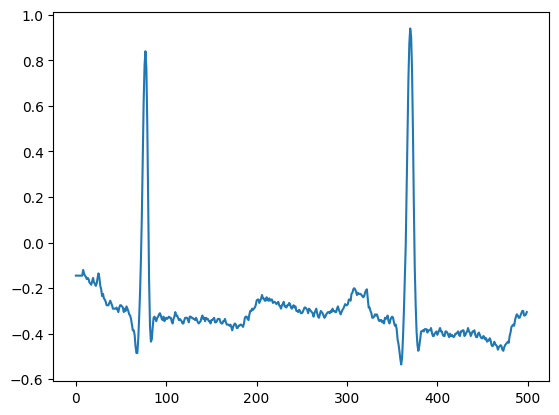

In [67]:
# Ploting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

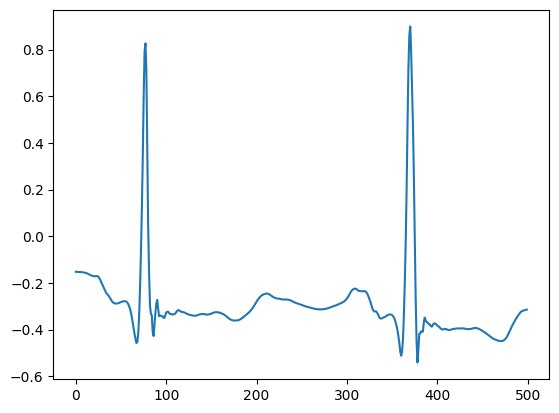

In [68]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

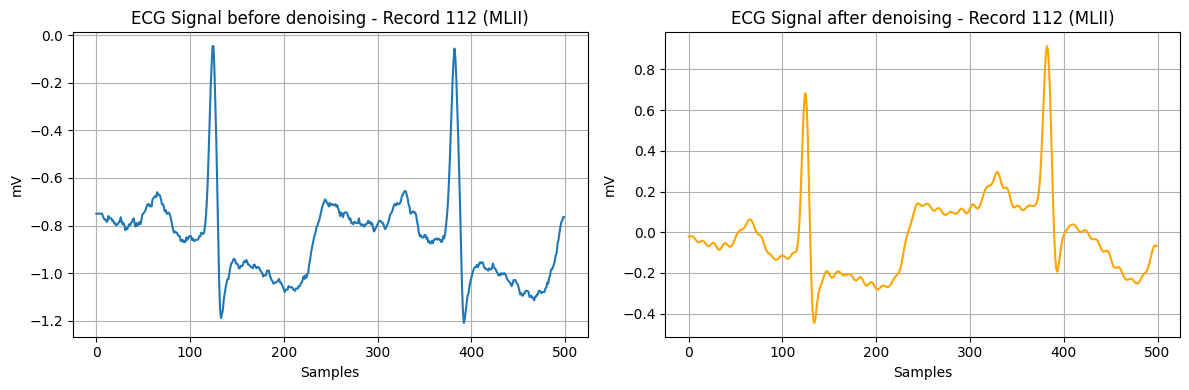

In [69]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt

# Simple bandpass filter for denoising
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Load ECG (record 100, MLII lead)
DATA_ROOT = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"
record_id = "112"
record_path = f"{DATA_ROOT}/{record_id}"
signals, info = wfdb.rdsamp(record_path)

fs = info['fs']       # sampling frequency
ecg = signals[:500,0] # take 500 samples from MLII lead for demo

# Apply denoising
ecg_denoised = bandpass_filter(ecg, fs=fs)

# Plot before and after
plt.figure(figsize=(12, 4))

# Before
plt.subplot(1, 2, 1)
plt.plot(ecg)
plt.title(f"ECG Signal before denoising - Record {record_id} (MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)

# After
plt.subplot(1, 2, 2)
plt.plot(ecg_denoised, color="orange")
plt.title(f"ECG Signal after denoising - Record {record_id} (MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)

plt.tight_layout()
plt.show()

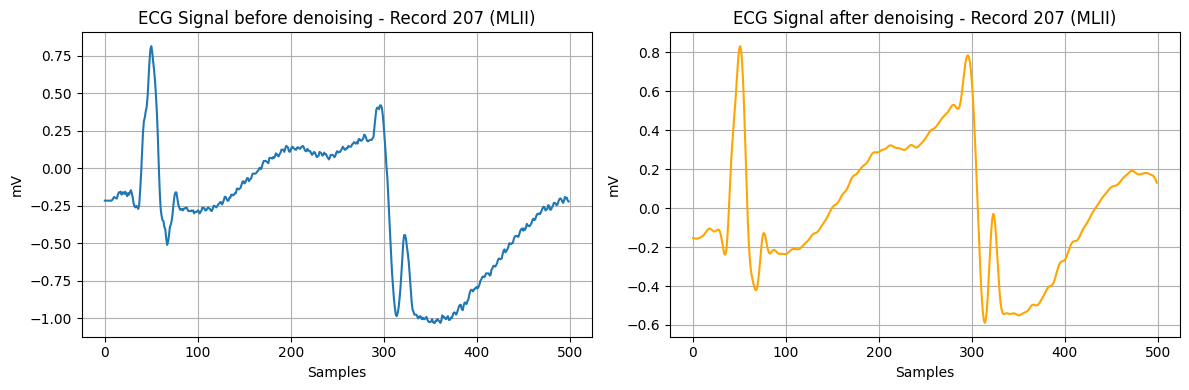

In [70]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt

# Simple bandpass filter for denoising
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Load ECG (record 100, MLII lead)
DATA_ROOT = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"
record_id = "207"
record_path = f"{DATA_ROOT}/{record_id}"
signals, info = wfdb.rdsamp(record_path)

fs = info['fs']       # sampling frequency
ecg = signals[:500,0] # take 500 samples from MLII lead for demo

# Apply denoising
ecg_denoised = bandpass_filter(ecg, fs=fs)

# Plot before and after
plt.figure(figsize=(12, 4))

# Before
plt.subplot(1, 2, 1)
plt.plot(ecg)
plt.title(f"ECG Signal before denoising - Record {record_id} (MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)

# After
plt.subplot(1, 2, 2)
plt.plot(ecg_denoised, color="orange")
plt.title(f"ECG Signal after denoising - Record {record_id} (MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)

plt.tight_layout()
plt.show()

### **B2: R-Peak Detection**
R-peak is annotated in MIT-BIH dataset. Just need to read the file.

In [71]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

Beat counts: Counter({'N': 2537, '~': 10, 'A': 2, '+': 1})


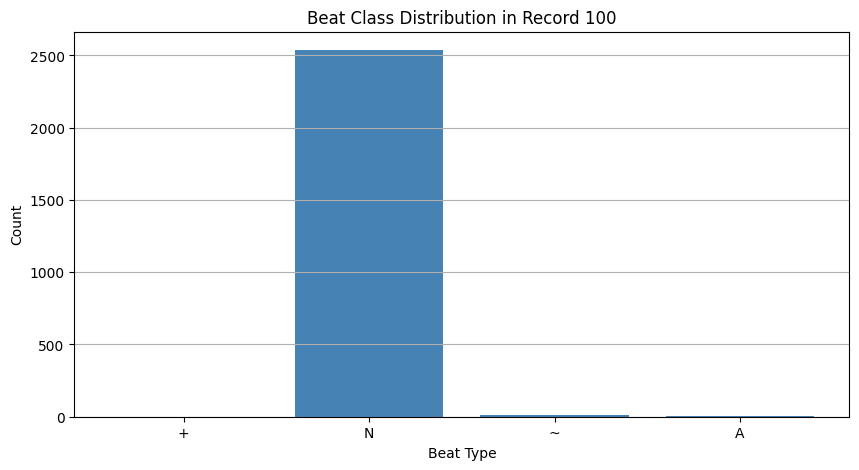

In [72]:
import wfdb
import matplotlib.pyplot as plt
from collections import Counter

# Path to dataset
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Load annotations for record 100
annotation = wfdb.rdann(project_path + "112", 'atr')

# Count beats by symbol
beat_counts = Counter(annotation.symbol)

# Print counts
print("Beat counts:", beat_counts)

# Plot as bar chart
plt.figure(figsize=(10,5))
plt.bar(beat_counts.keys(), beat_counts.values(), color="steelblue")
plt.title("Beat Class Distribution in Record 100")
plt.xlabel("Beat Type")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

Beat counts: Counter({'L': 1457, '!': 472, 'A': 107, 'V': 105, 'E': 105, 'R': 86, '+': 24, '~': 15, '[': 6, ']': 6, '|': 2})


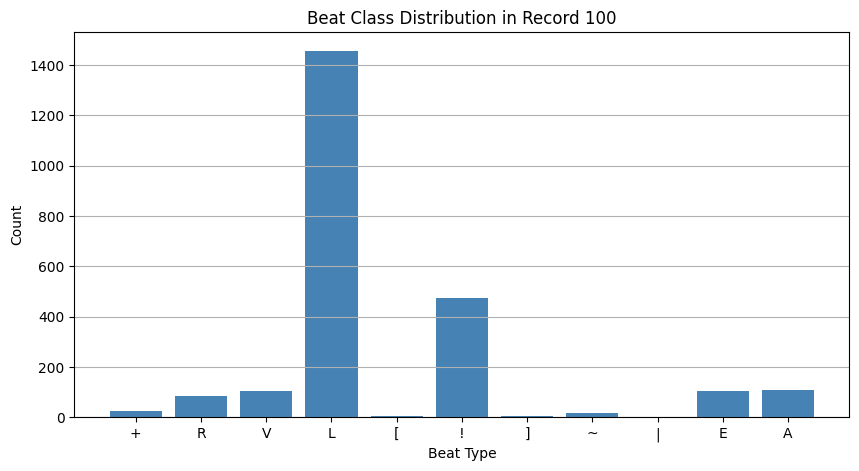

In [73]:
import wfdb
import matplotlib.pyplot as plt
from collections import Counter

# Path to dataset
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Load annotations for record 100
annotation = wfdb.rdann(project_path + "207", 'atr')

# Count beats by symbol
beat_counts = Counter(annotation.symbol)

# Print counts
print("Beat counts:", beat_counts)

# Plot as bar chart
plt.figure(figsize=(10,5))
plt.bar(beat_counts.keys(), beat_counts.values(), color="steelblue")
plt.title("Beat Class Distribution in Record 100")
plt.xlabel("Beat Type")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

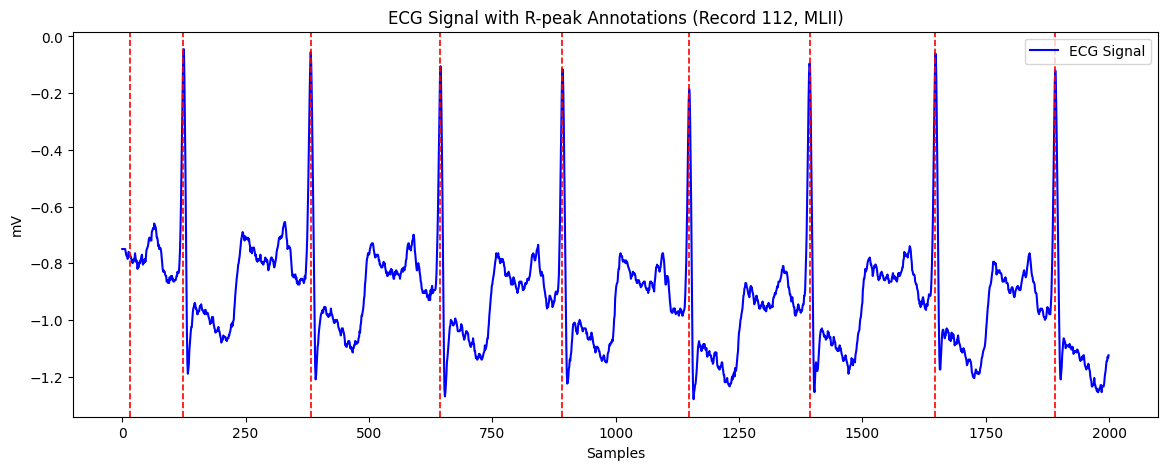

In [74]:
import matplotlib.pyplot as plt
import wfdb

# Example: Record 112
dataset_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"
record_id = "112"
record_path = f"{dataset_path}/{record_id}"

# Load signals & annotations
signals, info = wfdb.rdsamp(record_path)
annotation = wfdb.rdann(record_path, "atr")

# Take first 2000 samples (MLII lead)
ecg = signals[:2000,0]
r_peaks = annotation.sample[(annotation.sample < 2000)]

# Plot ECG
plt.figure(figsize=(14,5))
plt.plot(ecg, label="ECG Signal", color="blue")

# Mark R-peaks with red vertical lines
for r in r_peaks:
    plt.axvline(x=r, color="red", linestyle="--", linewidth=1.2)

plt.title(f"ECG Signal with R-peak Annotations (Record {record_id}, MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.legend()
plt.show()

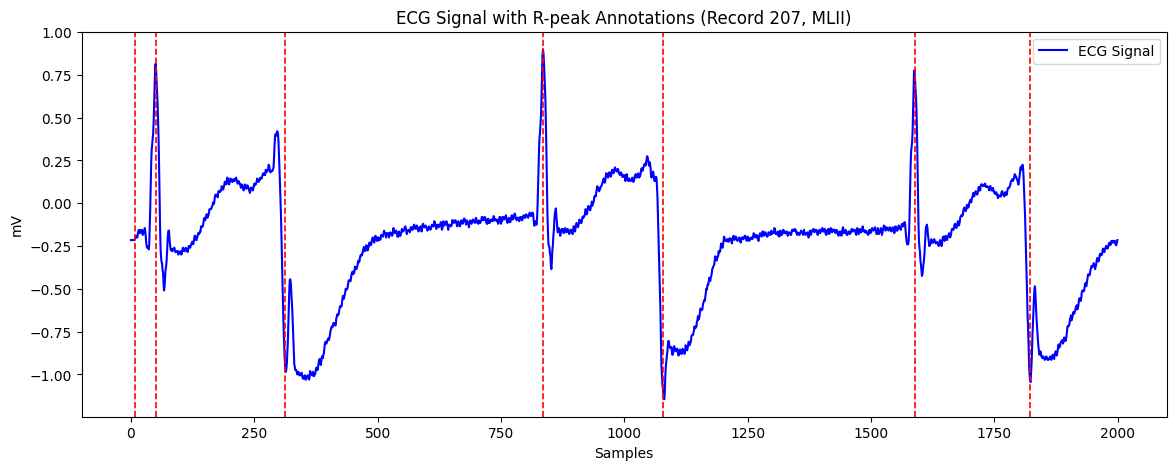

In [75]:
import matplotlib.pyplot as plt
import wfdb

# Example: Record 207
dataset_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0"
record_id = "207"
record_path = f"{dataset_path}/{record_id}"

# Load signals & annotations
signals, info = wfdb.rdsamp(record_path)
annotation = wfdb.rdann(record_path, "atr")

# Take first 2000 samples (MLII lead)
ecg = signals[:2000,0]
r_peaks = annotation.sample[(annotation.sample < 2000)]

# Plot ECG
plt.figure(figsize=(14,5))
plt.plot(ecg, label="ECG Signal", color="blue")

# Mark R-peaks with red vertical lines
for r in r_peaks:
    plt.axvline(x=r, color="red", linestyle="--", linewidth=1.2)

plt.title(f"ECG Signal with R-peak Annotations (Record {record_id}, MLII)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.legend()
plt.show()

In [76]:
len(annotation.symbol)

2385

Available leads: ['MLII', 'V1']
Annotation symbols: {'N', '+'}


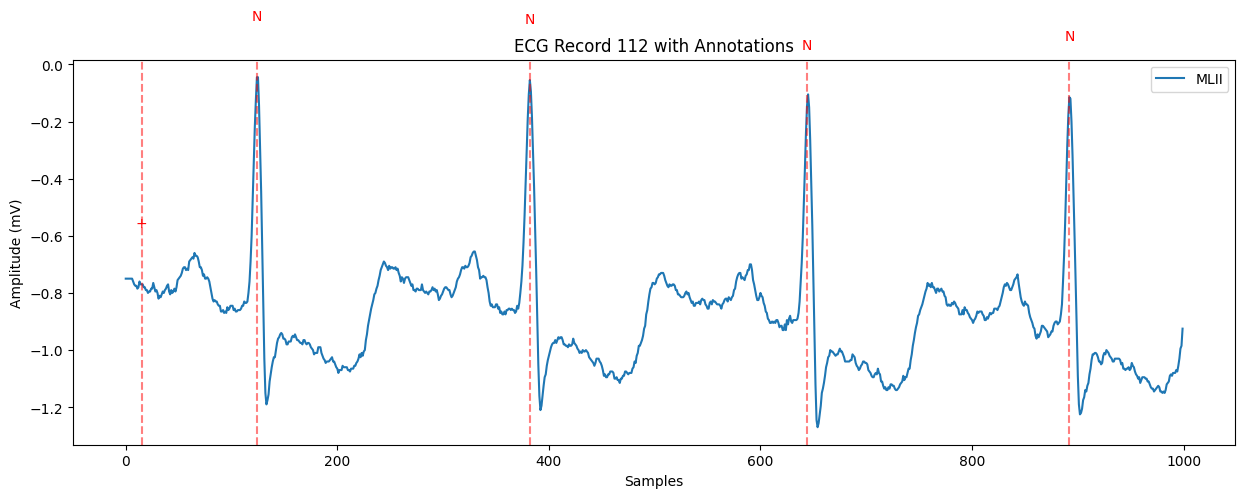

In [77]:
import wfdb
import matplotlib.pyplot as plt

project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Load record (record 100) and annotation
record = wfdb.rdrecord(project_path + "112")
annotation = wfdb.rdann(project_path + "112", "atr")

print("Available leads:", record.sig_name)
print("Annotation symbols:", set(annotation.symbol[:20]))  # show first 20

# Plot first 1000 samples
plt.figure(figsize=(15,5))
plt.plot(record.p_signal[:1000,0], label=record.sig_name[0])

# Overlay annotations
for i, sample in enumerate(annotation.sample):
    if sample < 1000:  # only show within first 1000 samples
        plt.axvline(x=sample, color='r', linestyle='--', alpha=0.5)  # vertical marker
        plt.text(sample, record.p_signal[sample,0]+0.2, annotation.symbol[i],
                 color='red', fontsize=10, rotation=0, ha='center')

plt.title("ECG Record 112 with Annotations")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

Available leads: ['MLII', 'V1']
Annotation symbols: {'V', 'R', '+'}


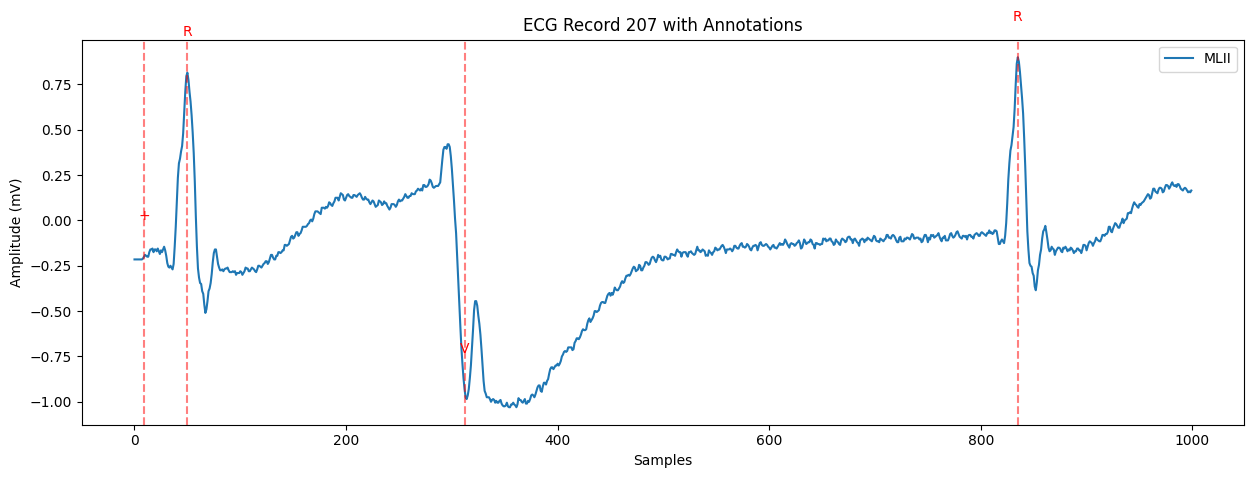

In [78]:
import wfdb
import matplotlib.pyplot as plt

project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Load record (record 100) and annotation
record = wfdb.rdrecord(project_path + "207")
annotation = wfdb.rdann(project_path + "207", "atr")

print("Available leads:", record.sig_name)
print("Annotation symbols:", set(annotation.symbol[:20]))  # show first 20

# Plot first 1000 samples
plt.figure(figsize=(15,5))
plt.plot(record.p_signal[:1000,0], label=record.sig_name[0])

# Overlay annotations
for i, sample in enumerate(annotation.sample):
    if sample < 1000:  # only show within first 1000 samples
        plt.axvline(x=sample, color='r', linestyle='--', alpha=0.5)  # vertical marker
        plt.text(sample, record.p_signal[sample,0]+0.2, annotation.symbol[i],
                 color='red', fontsize=10, rotation=0, ha='center')

plt.title("ECG Record 207 with Annotations")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

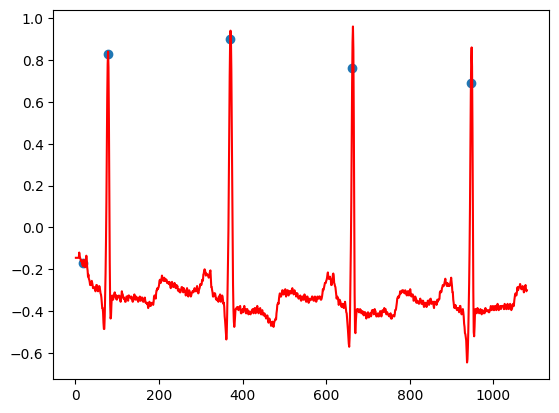

In [79]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

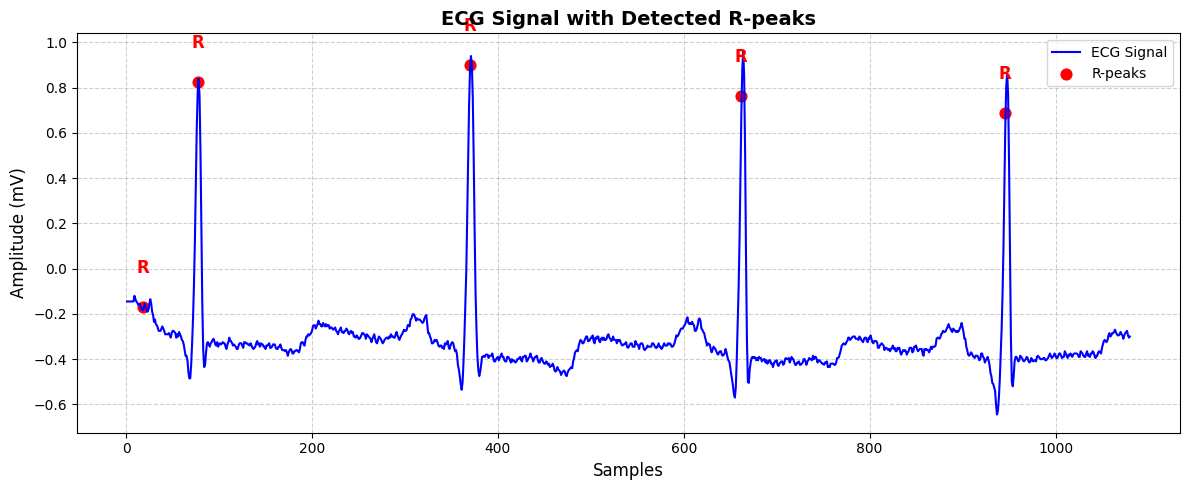

In [80]:
import matplotlib.pyplot as plt
import numpy as np


# Example variables from your code
x = np.arange(1, 1081)
n_peak = 5
r_peak_x = []
r_peak_y = []

for i in range(0, n_peak):
    r_peak_x.append(Rlocation[i])
    r_peak_y.append(rdata[Rlocation[i]])

# Plot ECG waveform
plt.figure(figsize=(12,5))
plt.plot(x, data[0:1080], color='blue', label='ECG Signal')

# Plot R-peaks
plt.scatter(r_peak_x, r_peak_y, color='red', marker='o', s=60, label='R-peaks')

# Annotate R-peaks
for i in range(len(r_peak_x)):
    plt.text(r_peak_x[i], r_peak_y[i]+0.15, "R", color='red',
             fontsize=12, ha='center', fontweight='bold')

# Labels and formatting
plt.title("ECG Signal with Detected R-peaks", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Available leads: ['MLII', 'V1']
Annotation symbols (first 10): ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


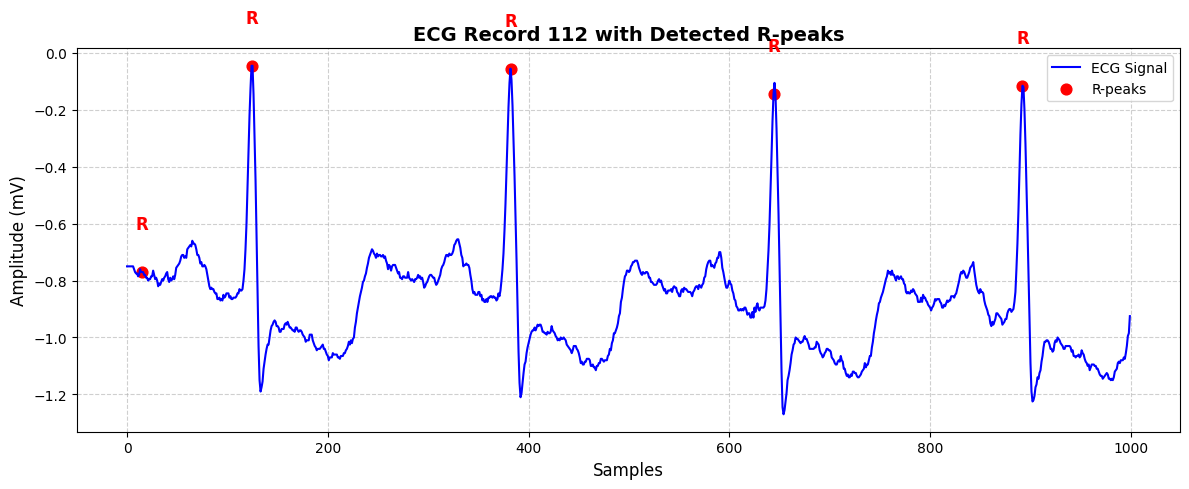

In [81]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# ========================
# Load Record 112
# ========================
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"
record = wfdb.rdrecord(project_path + "112")
annotation = wfdb.rdann(project_path + "112", "atr")

print("Available leads:", record.sig_name)
print("Annotation symbols (first 10):", annotation.symbol[:10])

# ========================
# Extract ECG Signal
# ========================
data = record.p_signal[:,0]   # Use lead MLII (channel 0)
x = np.arange(len(data))

# ========================
# Take first 1000 samples for visualization
# ========================
n_samples = 1000
signal = data[:n_samples]

# ========================
# R-peaks from annotation
# ========================
Rlocation = [s for i,s in enumerate(annotation.sample) if s < n_samples]
r_peak_x = Rlocation
r_peak_y = [data[i] for i in Rlocation]

# ========================
# Plot ECG + R-peaks
# ========================
plt.figure(figsize=(12,5))
plt.plot(x[:n_samples], signal, color='blue', label='ECG Signal')

# Highlight R-peaks
plt.scatter(r_peak_x, r_peak_y, color='red', marker='o', s=60, label='R-peaks')

# Annotate with "R"
for i in range(len(r_peak_x)):
    plt.text(r_peak_x[i], r_peak_y[i]+0.15, "R", color='red',
             fontsize=12, ha='center', fontweight='bold')

plt.title("ECG Record 112 with Detected R-peaks", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Available leads: ['MLII', 'V1']
Annotation symbols (first 10): ['+', 'R', 'V', 'R', 'V', 'R', 'V', 'R', 'V', 'R']


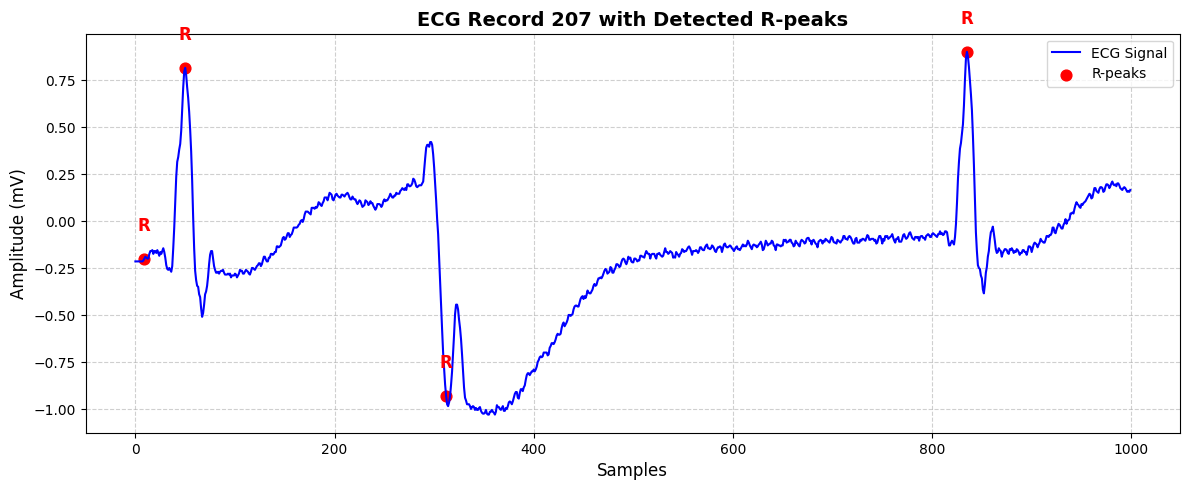

In [82]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# ========================
# Load Record 207
# ========================
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"
record = wfdb.rdrecord(project_path + "207")
annotation = wfdb.rdann(project_path + "207", "atr")

print("Available leads:", record.sig_name)
print("Annotation symbols (first 10):", annotation.symbol[:10])

# ========================
# Extract ECG Signal
# ========================
data = record.p_signal[:,0]   # Use lead MLII (channel 0)
x = np.arange(len(data))

# ========================
# Take first 1000 samples for visualization
# ========================
n_samples = 1000
signal = data[:n_samples]

# ========================
# R-peaks from annotation
# ========================
Rlocation = [s for i,s in enumerate(annotation.sample) if s < n_samples]
r_peak_x = Rlocation
r_peak_y = [data[i] for i in Rlocation]

# ========================
# Plot ECG + R-peaks
# ========================
plt.figure(figsize=(12,5))
plt.plot(x[:n_samples], signal, color='blue', label='ECG Signal')

# Highlight R-peaks
plt.scatter(r_peak_x, r_peak_y, color='red', marker='o', s=60, label='R-peaks')

# Annotate with "R"
for i in range(len(r_peak_x)):
    plt.text(r_peak_x[i], r_peak_y[i]+0.15, "R", color='red',
             fontsize=12, ha='center', fontweight='bold')

plt.title("ECG Record 207 with Detected R-peaks", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### **B3: Segmentation**
Each ECG signal is segmented by using a window **length of 300**. From R-peak location, **99** samples taken from **left** and **201** samples from **right**. Thus a complete **heartbeat** is found.

(300,)
(300,)


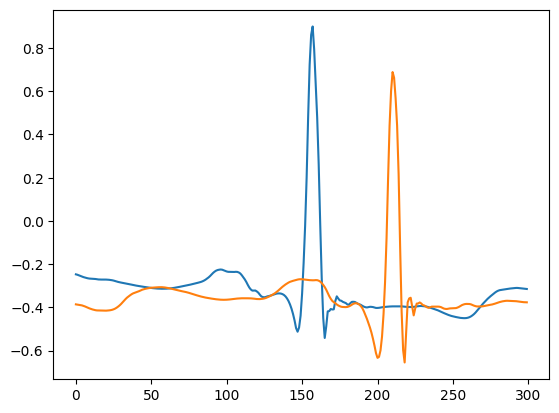

In [83]:
for i in range(len(Rlocation)):
    start = Rlocation[i] - 99
    end = Rlocation[i] + 201

    # Skip if window goes out of bounds
    if start < 0 or end > len(rdata):
        continue

    x_train = rdata[start:end]
    plt.plot(x_train)
    print(x_train.shape)

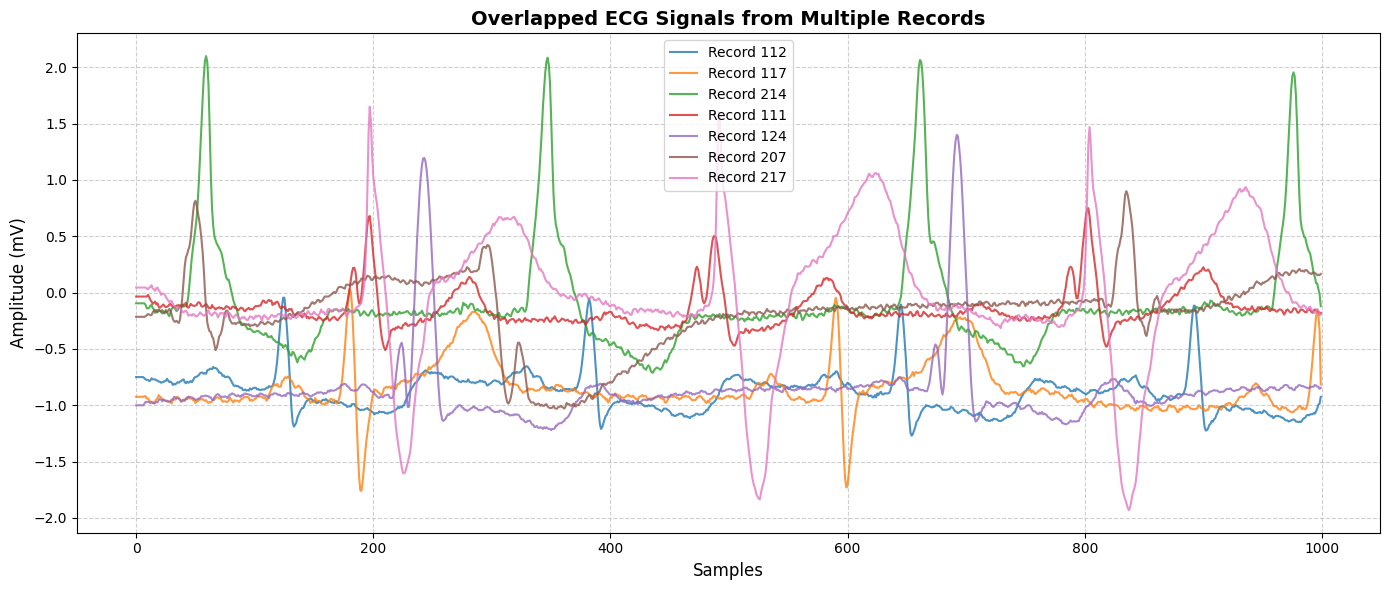

In [84]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# ========================
# Settings
# ========================
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"
records = ["112", "117", "214", "111", "124", "207", "217"]
n_samples = 1000  # number of samples to plot

plt.figure(figsize=(14,6))

# ========================
# Loop through records
# ========================
for rec in records:
    record = wfdb.rdrecord(project_path + rec)
    data = record.p_signal[:,0]   # channel 0 (MLII lead)
    x = np.arange(len(data))

    # Plot first n_samples
    plt.plot(x[:n_samples], data[:n_samples], label=f"Record {rec}", alpha=0.8)

# ========================
# Formatting
# ========================
plt.title("Overlapped ECG Signals from Multiple Records", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

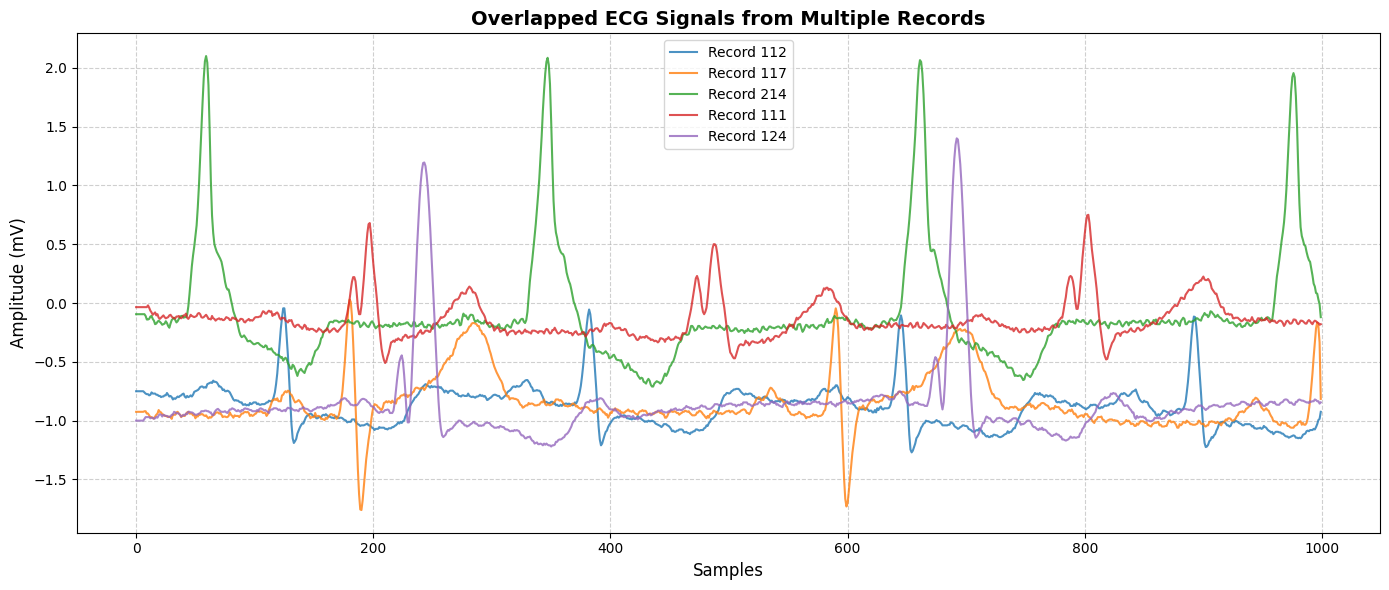

In [85]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# ========================
# Settings
# ========================
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"
records = ["112", "117", "214", "111", "124"]
n_samples = 1000  # number of samples to plot

plt.figure(figsize=(14,6))

# ========================
# Loop through records
# ========================
for rec in records:
    record = wfdb.rdrecord(project_path + rec)
    data = record.p_signal[:,0]   # channel 0 (MLII lead)
    x = np.arange(len(data))

    # Plot first n_samples
    plt.plot(x[:n_samples], data[:n_samples], label=f"Record {rec}", alpha=0.8)

# ========================
# Formatting
# ========================
plt.title("Overlapped ECG Signals from Multiple Records", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### **B4: Complete Preprocessing Figures**
The complete preprocessing including denosinsing, R-peak location detection and segmentation is expected to view in a single figure.

In [86]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

/tmp/ipython-input-2254658123.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


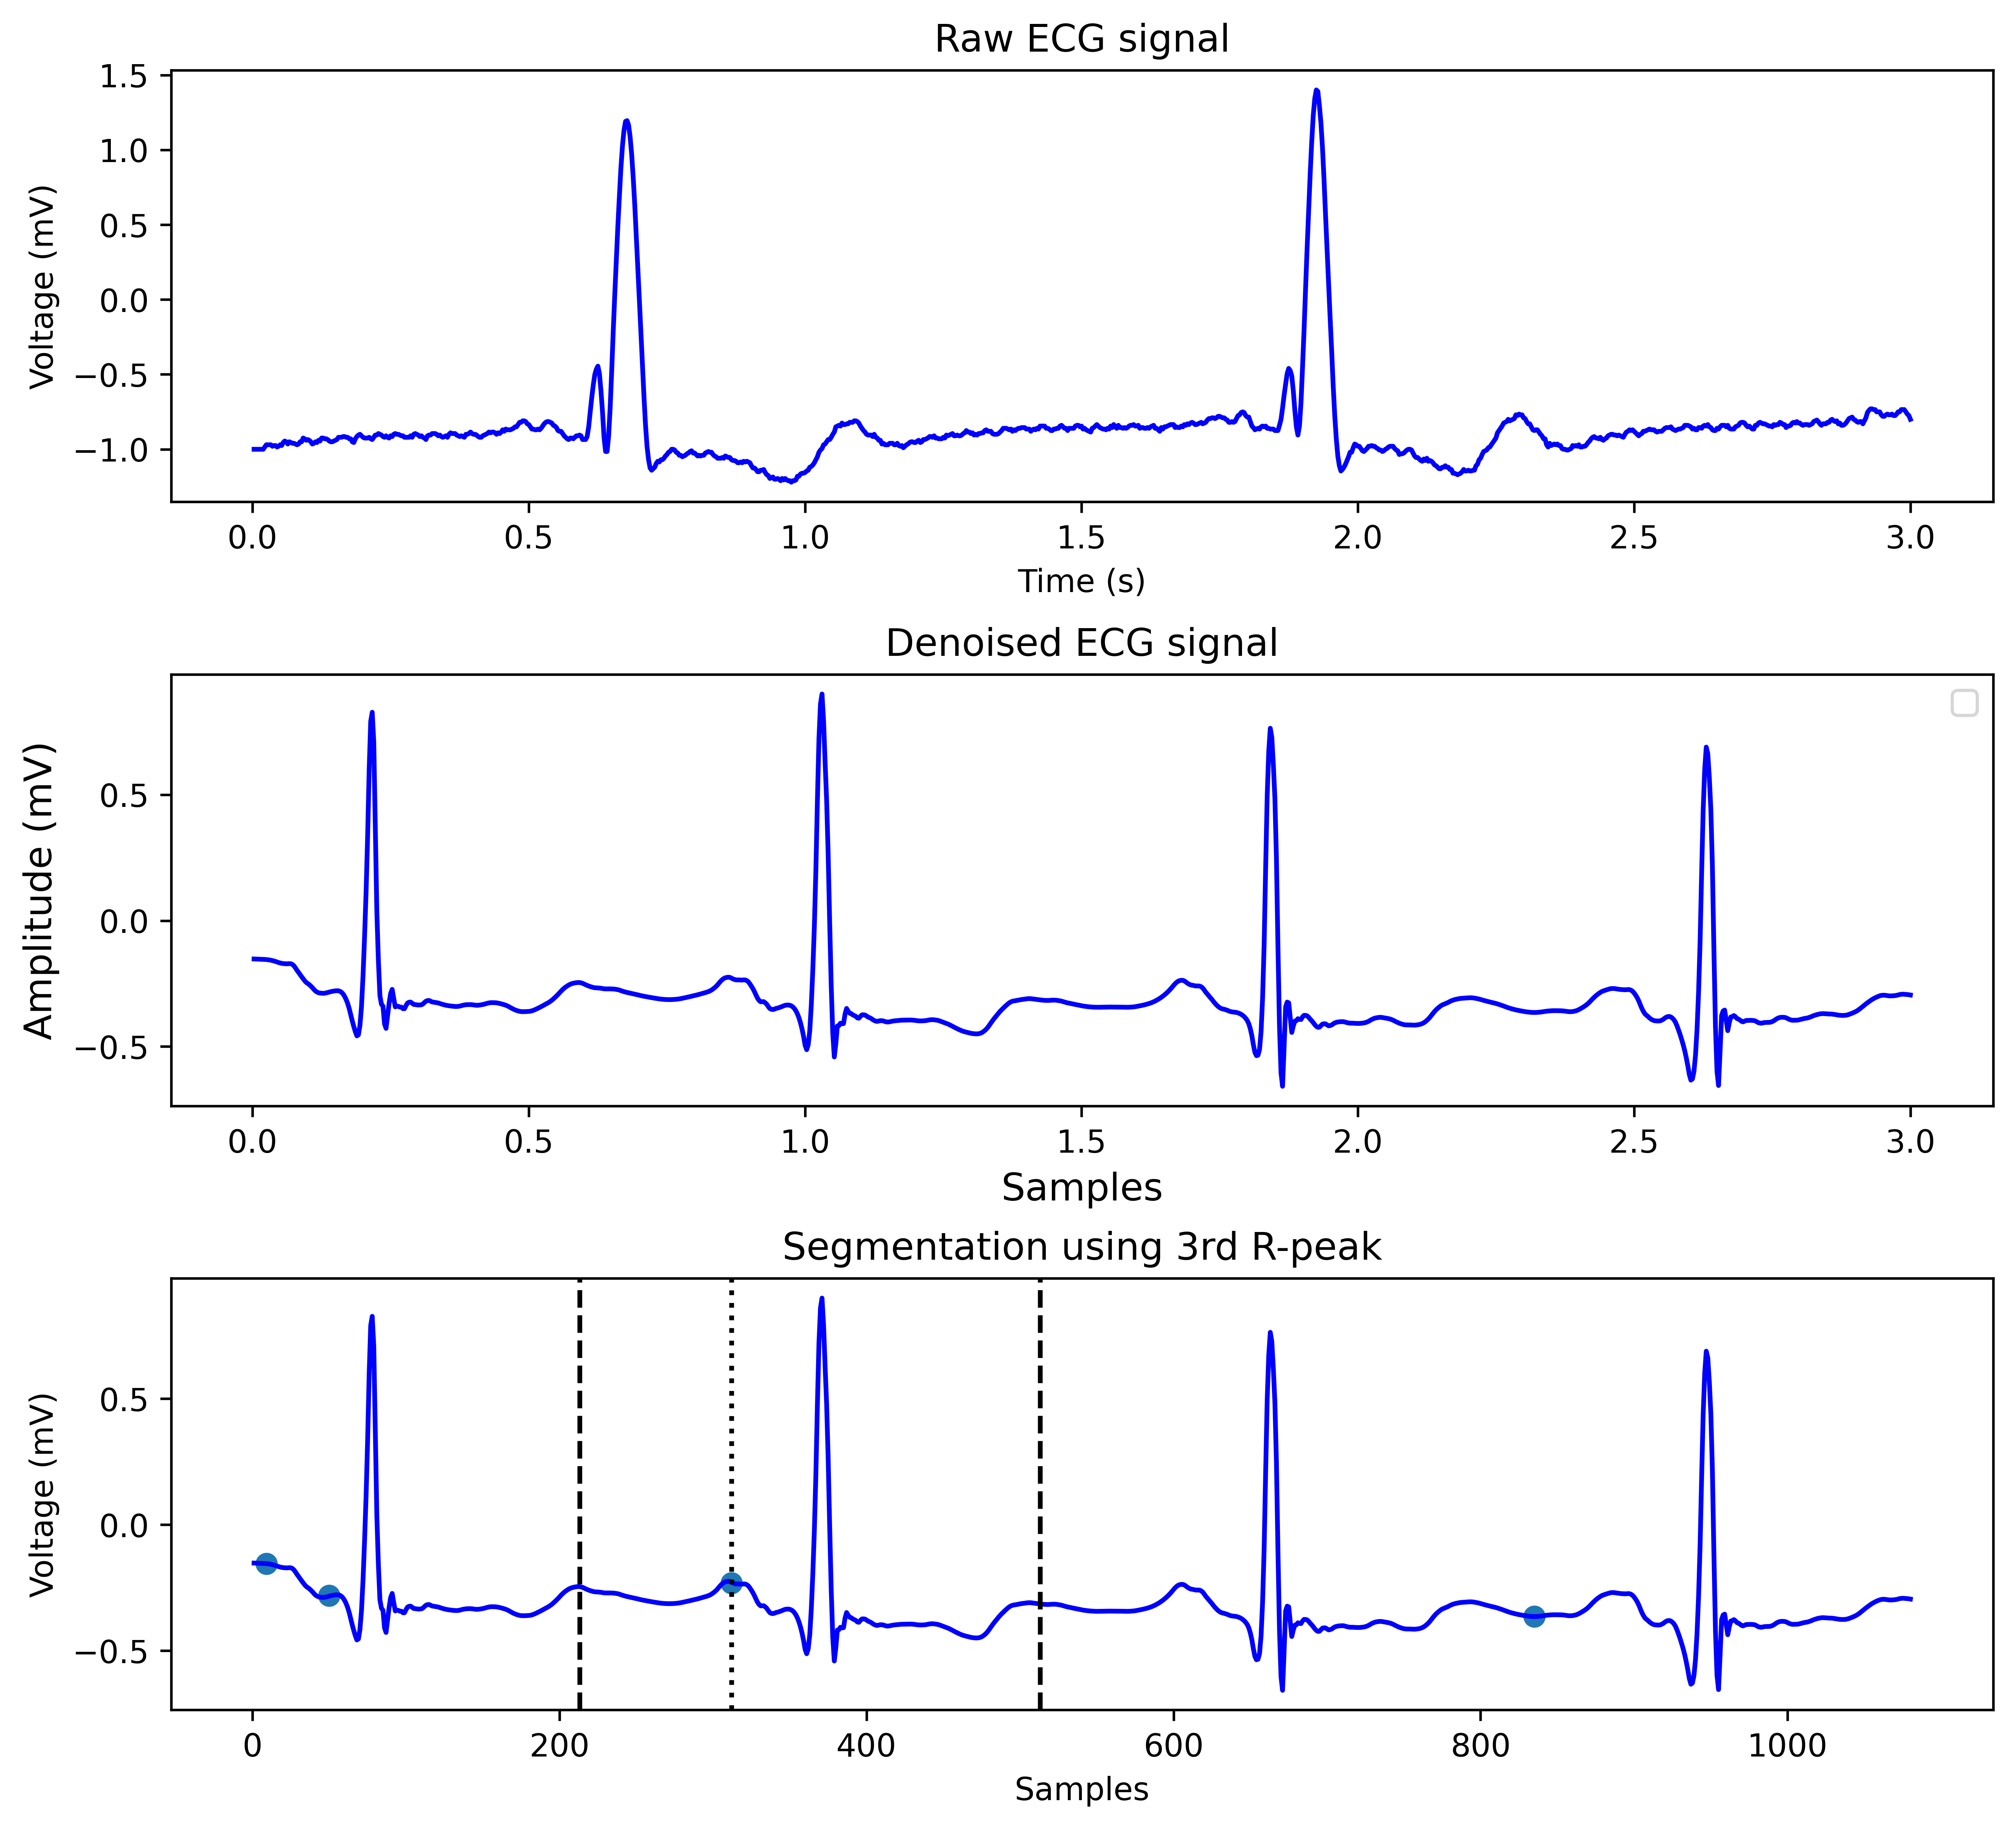

In [87]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='blue')
plt.title('Denoised ECG signal')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
n_peak = min(5, len(Rlocation))
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='blue')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

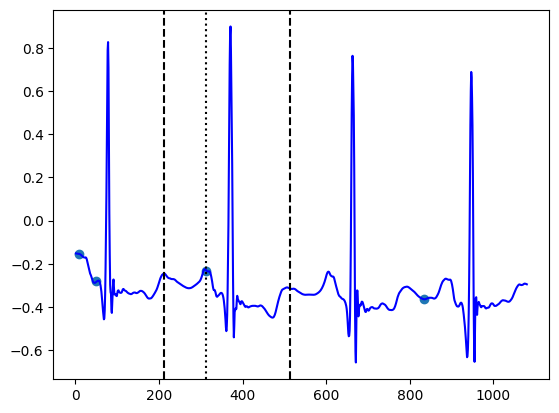

In [88]:
n_peak = min(5, len(Rlocation))
r_peak_x = []
r_peak_y = []
for i in range(n_peak):
    r_peak_x.append(Rlocation[i])
    r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, rdata[0:1080], color='blue')
plt.scatter(r_peak_x, r_peak_y)

if len(Rlocation) > 2:
    plt.axvline(x=Rlocation[2], color='k', linestyle=':')
    plt.axvline(x=Rlocation[2] - 99, color='k', linestyle='--')
    plt.axvline(x=Rlocation[2] + 201, color='k', linestyle='--')
else:
    print("Not enough R peaks for segmentation lines")


# **Part C: Dataset Loading**

## **C1: Loading whole data**

In [89]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [90]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [91]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [92]:
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(0.0): 74920,
         np.float64(1.0): 8063,
         np.float64(9.0): 7123,
         np.float64(12.0): 7012,
         np.float64(2.0): 7244,
         np.float64(5.0): 2540,
         np.float64(11.0): 802,
         np.float64(13.0): 982,
         np.float64(4.0): 229,
         np.float64(7.0): 83,
         np.float64(6.0): 150,
         np.float64(14.0): 33,
         np.float64(10.0): 106,
         np.float64(3.0): 16,
         np.float64(8.0): 2})

## **C2: Ploting 15 Different Heartbeats**

In [93]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [94]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [95]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']

  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)',
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)',
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)',
                  'Supraventricular prem. (S)', 'Premature ventr. (V)',
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)',
                  'Paced (/)', 'Fusion of pa. & no. (f)',
                  'Unclassifiable(Q)']

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)

  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

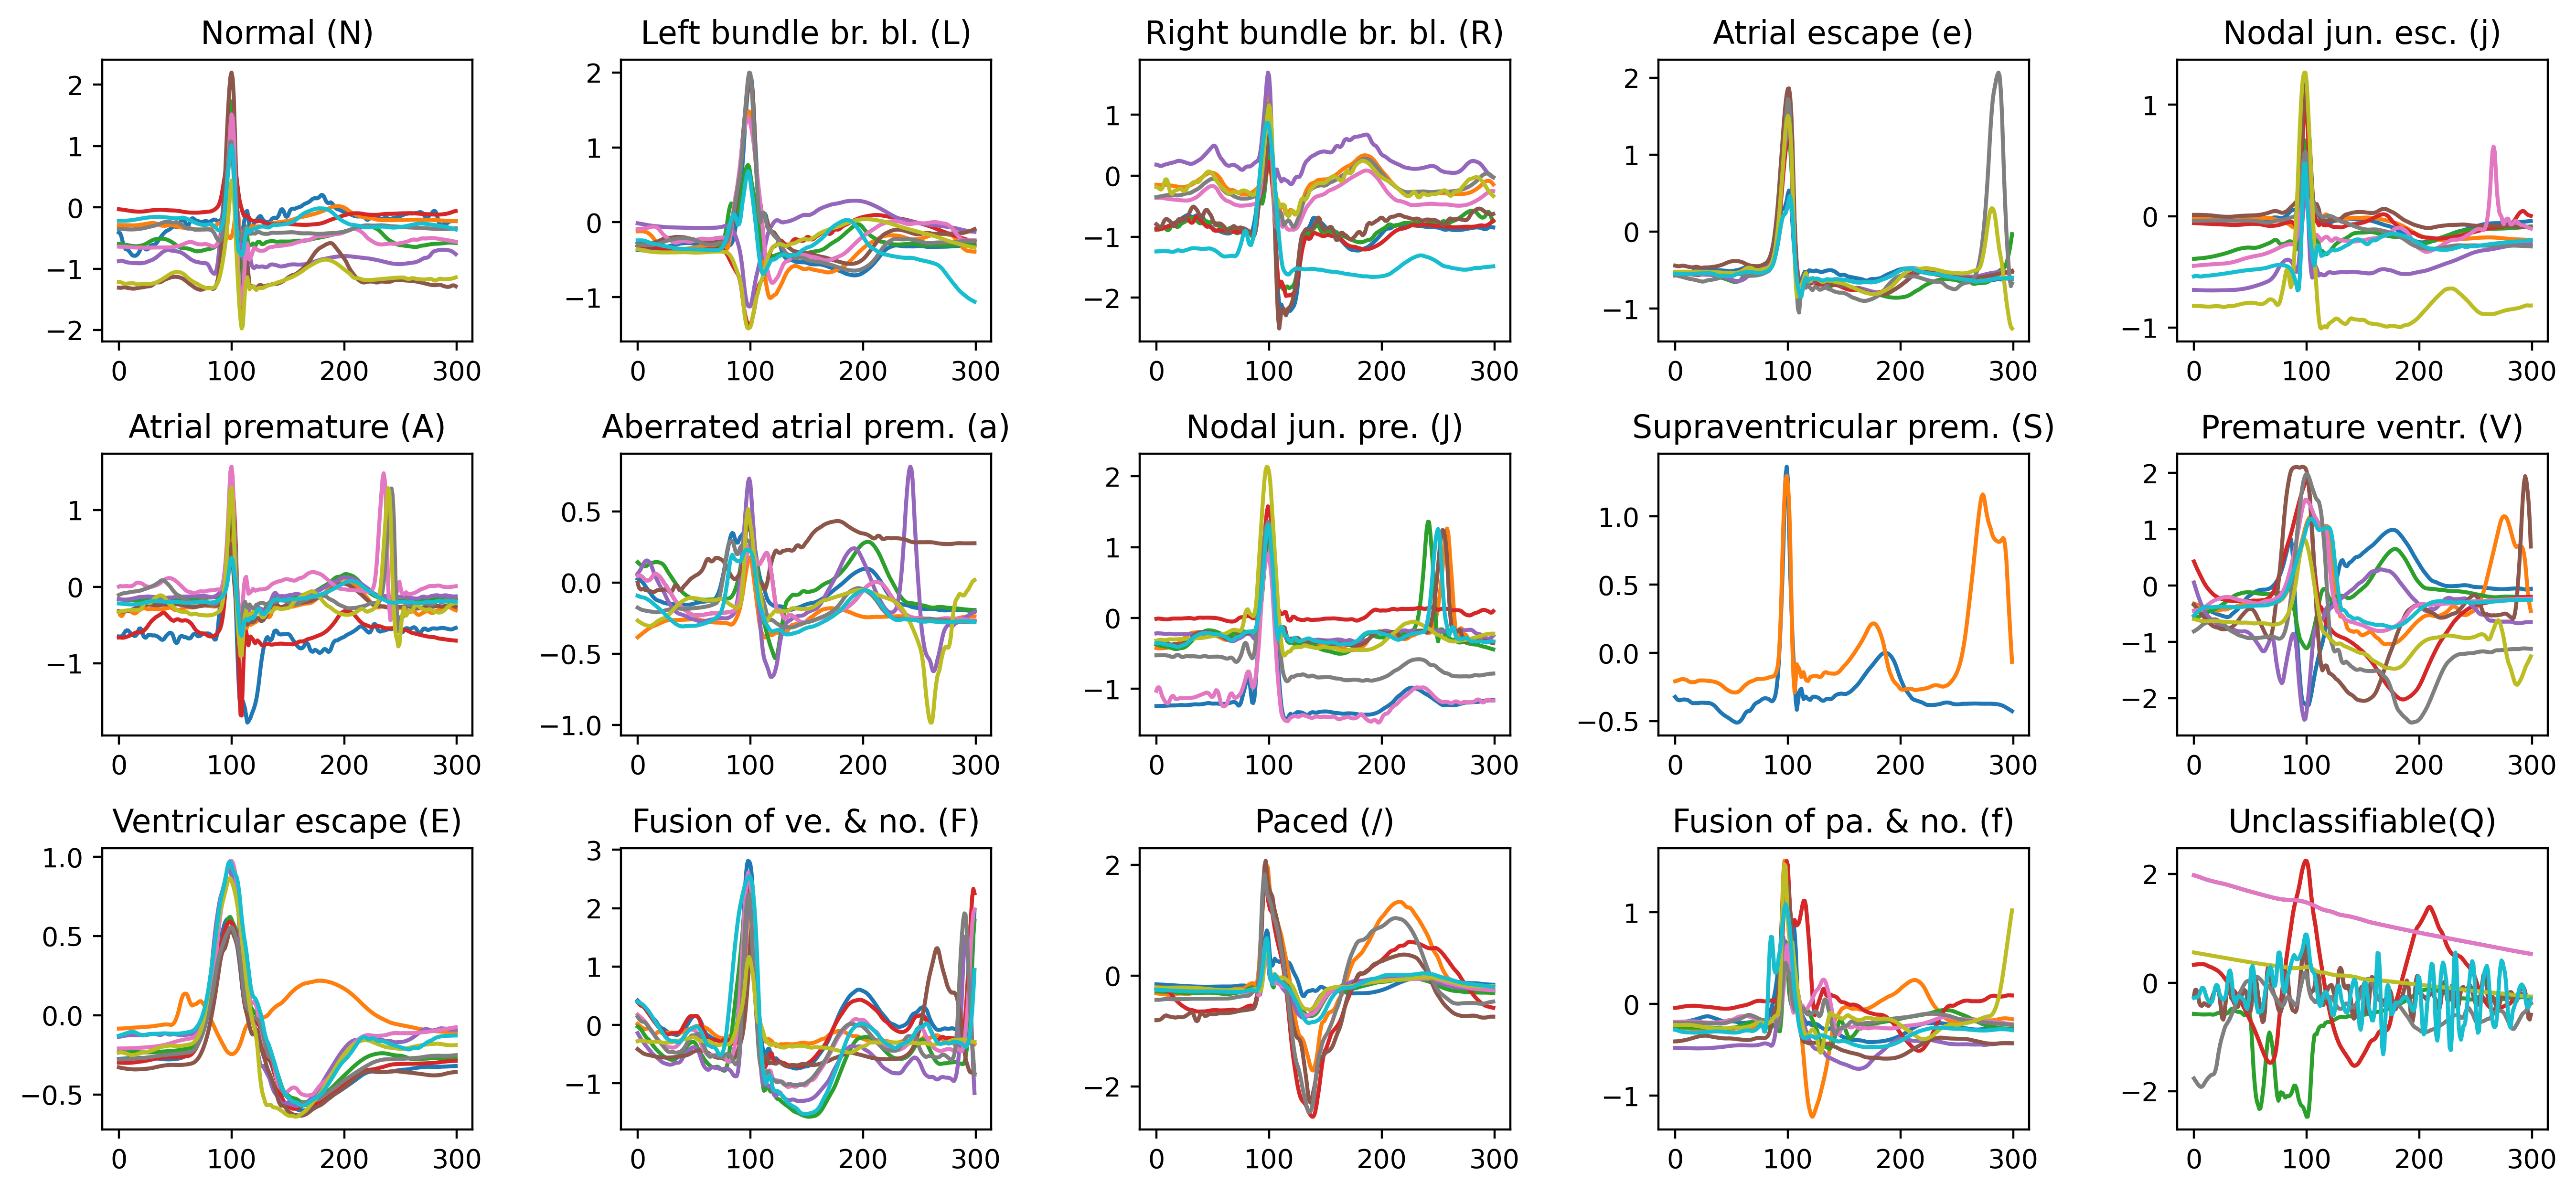

In [96]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
# figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
# fig.savefig(figure_path+ 'all_heartbeats.png')

# **Part D: Train-Test Splitting and Class Balancing**

## **D1: Data loading**
Data is already loaded, **this step can be skipped.** However, here the whole dataset is saved in a train_ds variable.

### **a. Load whole data**

In [97]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [98]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [99]:
Y = train_ds[:, 300]

In [100]:
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(2.0): 7244,
         np.float64(0.0): 74920,
         np.float64(13.0): 982,
         np.float64(12.0): 7012,
         np.float64(9.0): 7123,
         np.float64(1.0): 8063,
         np.float64(5.0): 2540,
         np.float64(11.0): 802,
         np.float64(6.0): 150,
         np.float64(10.0): 106,
         np.float64(4.0): 229,
         np.float64(3.0): 16,
         np.float64(7.0): 83,
         np.float64(14.0): 33,
         np.float64(8.0): 2})

### **b. 15 types to 5 level conversion**

In [101]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [102]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({np.float64(0.0): 90472,
         np.float64(4.0): 8027,
         np.float64(2.0): 7229,
         np.float64(1.0): 2775,
         np.float64(3.0): 802})

In [103]:
ecg_dataset = np.copy(train_ds)

In [104]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [105]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [106]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

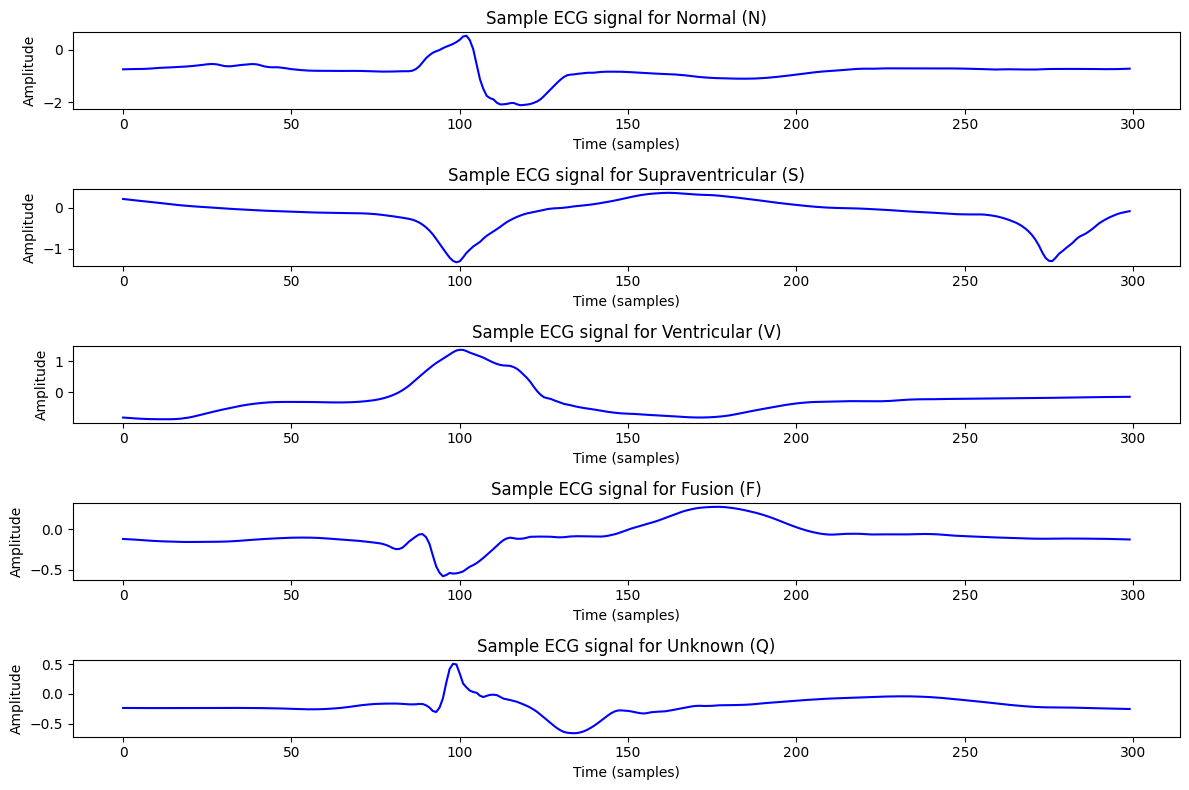

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose ecg_data is shape (N_samples, signal_length)
# and ecg_label is shape (N_samples,) with values 0-4 (5 arrhythmia classes)

classes = ["Normal (N)",
           "Supraventricular (S)",
           "Ventricular (V)",
           "Fusion (F)",
           "Unknown (Q)"]

plt.figure(figsize=(12, 8))

for i, cls in enumerate(np.unique(ecg_lable)):
    idx = np.where(ecg_lable == cls)[0][0]   # pick one example
    plt.subplot(5, 1, i+1)
    plt.plot(ecg_data[idx], color="blue")
    plt.title(f"Sample ECG signal for {classes[cls]}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


### **c. Per class data status checking (Full data)**

In [108]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

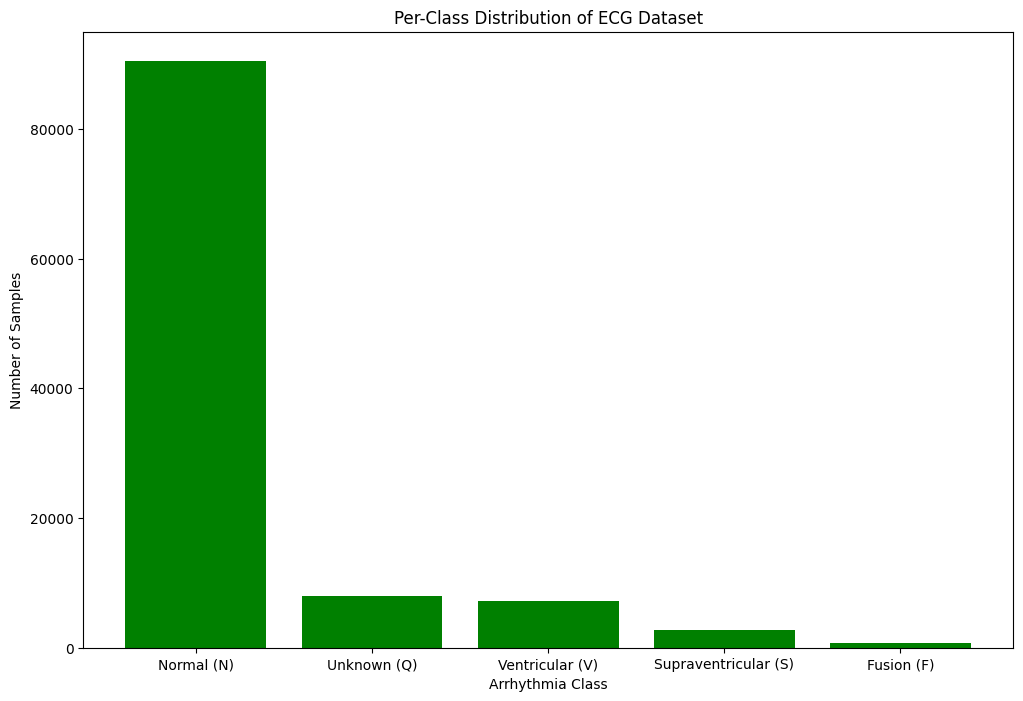

In [109]:
classes = ["Normal (N)", "Supraventricular (S)", "Ventricular (V)", "Fusion (F)", "Unknown (Q)"]
plt.figure(figsize=(12, 8))
plt.bar([classes[int(i)] for i in class_data.index], class_data.values, color='green')
plt.title("Per-Class Distribution of ECG Dataset")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.show()

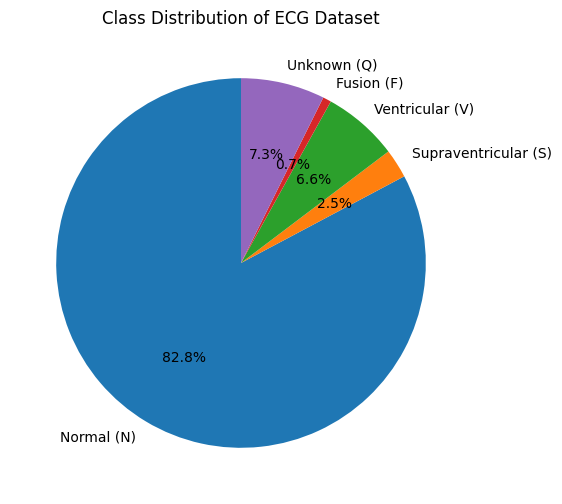

In [110]:
import matplotlib.pyplot as plt
import numpy as np

classes = ["Normal (N)", "Supraventricular (S)", "Ventricular (V)", "Fusion (F)", "Unknown (Q)"]

unique, counts = np.unique(ecg_lable, return_counts=True)

plt.figure(figsize=(6,6))
plt.pie(counts, labels=[classes[i] for i in unique], autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution of ECG Dataset")
plt.show()

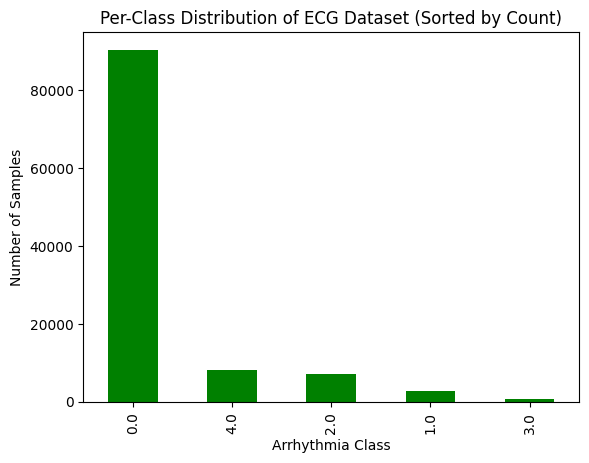

In [111]:
df_ecg[300].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
plt.title("Per-Class Distribution of ECG Dataset (Sorted by Count)")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.show()

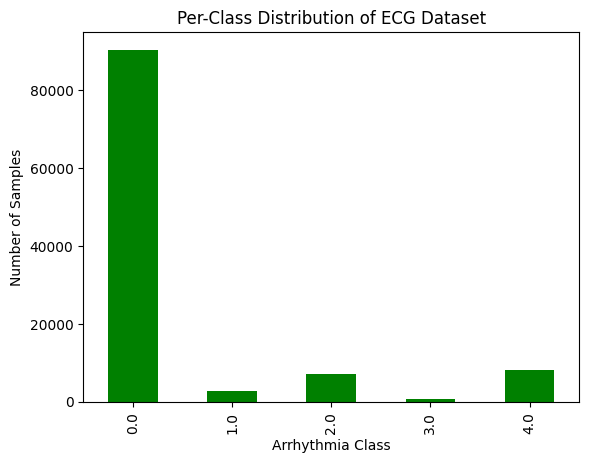

In [112]:
df_ecg[300].value_counts().sort_index().plot(kind='bar', color='green')
plt.title("Per-Class Distribution of ECG Dataset")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.show()

## **D2: Train-Test Spliting**
**Note: Class Balance should be done on Training Data Only. Not Testing Data.**

In [113]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.30,
                                   shuffle=True)

In [114]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [115]:
import pandas as pd

train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], -1))
train_df["label"] = y_train

test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], -1))
test_df["label"] = y_test

In [116]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [117]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

**Training dataset status checking:** balanced / imbalanced

300
0.0    63408
4.0     5568
2.0     5052
1.0     1940
3.0      545
Name: count, dtype: int64


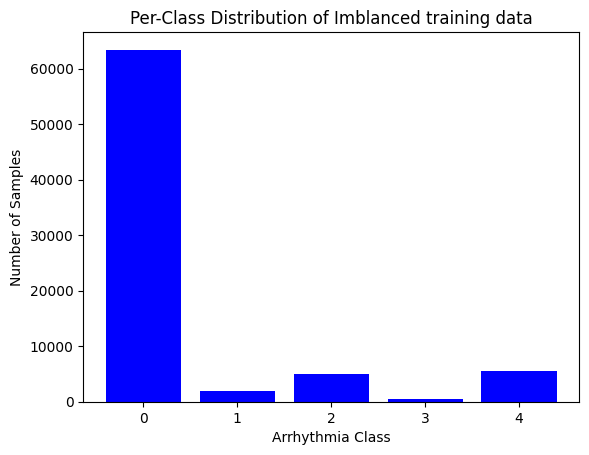

In [118]:
# Imblanced training data graph ploting
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='blue')
plt.title("Per-Class Distribution of Imblanced training data")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.show()

## **D3: Class balancing by undersampling and SMOTE**
**SMOTE** stands for '**Synthetic Minority Oversampling Technique**'.
Plan for train data
1. Class 1: Randomly selected 50000 data
2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

In [119]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [120]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=40000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [121]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:40000, 2:40000, 3:40000, 4:40000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [122]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-1.14438371e-03, -9.19210156e-03, -1.77646943e-02, ...,
        -8.50360459e-02, -5.77171908e-02,  3.00000000e+00],
       [ 2.42822722e-01,  2.36593643e-01,  2.29753448e-01, ...,
        -2.91774581e-02, -2.99986116e-02,  2.00000000e+00],
       [-2.61675611e-01, -2.60877494e-01, -2.58824787e-01, ...,
         9.79054442e-02,  3.00580461e-01,  0.00000000e+00],
       ...,
       [-2.77806561e-01, -2.85467330e-01, -2.92807272e-01, ...,
        -7.94772579e-01, -8.02752374e-01,  3.00000000e+00],
       [-2.61188188e-01, -2.71238172e-01, -2.77927846e-01, ...,
        -2.76484514e-01, -2.74784289e-01,  1.00000000e+00],
       [-3.63540730e-01, -3.64409510e-01, -3.66095619e-01, ...,
        -2.99590434e-01, -2.96401592e-01,  1.00000000e+00]])

300
3.0    40000
2.0    40000
0.0    40000
4.0    40000
1.0    40000
Name: count, dtype: int64


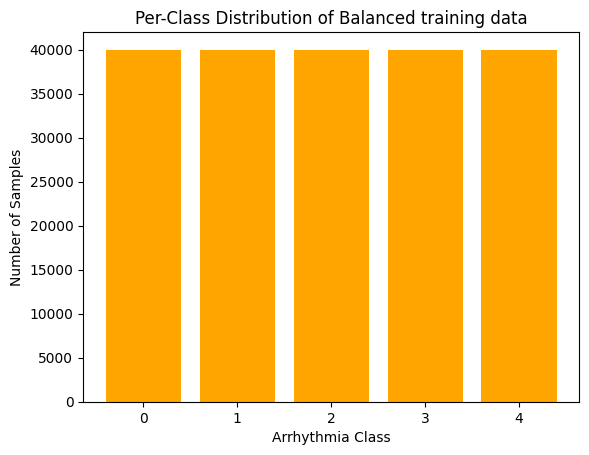

In [123]:
# Balanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='orange')
plt.title("Per-Class Distribution of Balanced training data")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.show()

# save balanced training data
#file_name = project_path + 'train_data_SMOTE.pkl'
#train_data_r.to_pickle(file_name)

In [124]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

/tmp/ipython-input-4237126612.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=['N', 'S', 'V', 'F', 'Q'],
/tmp/ipython-input-4237126612.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=['N', 'S', 'V', 'F', 'Q'],


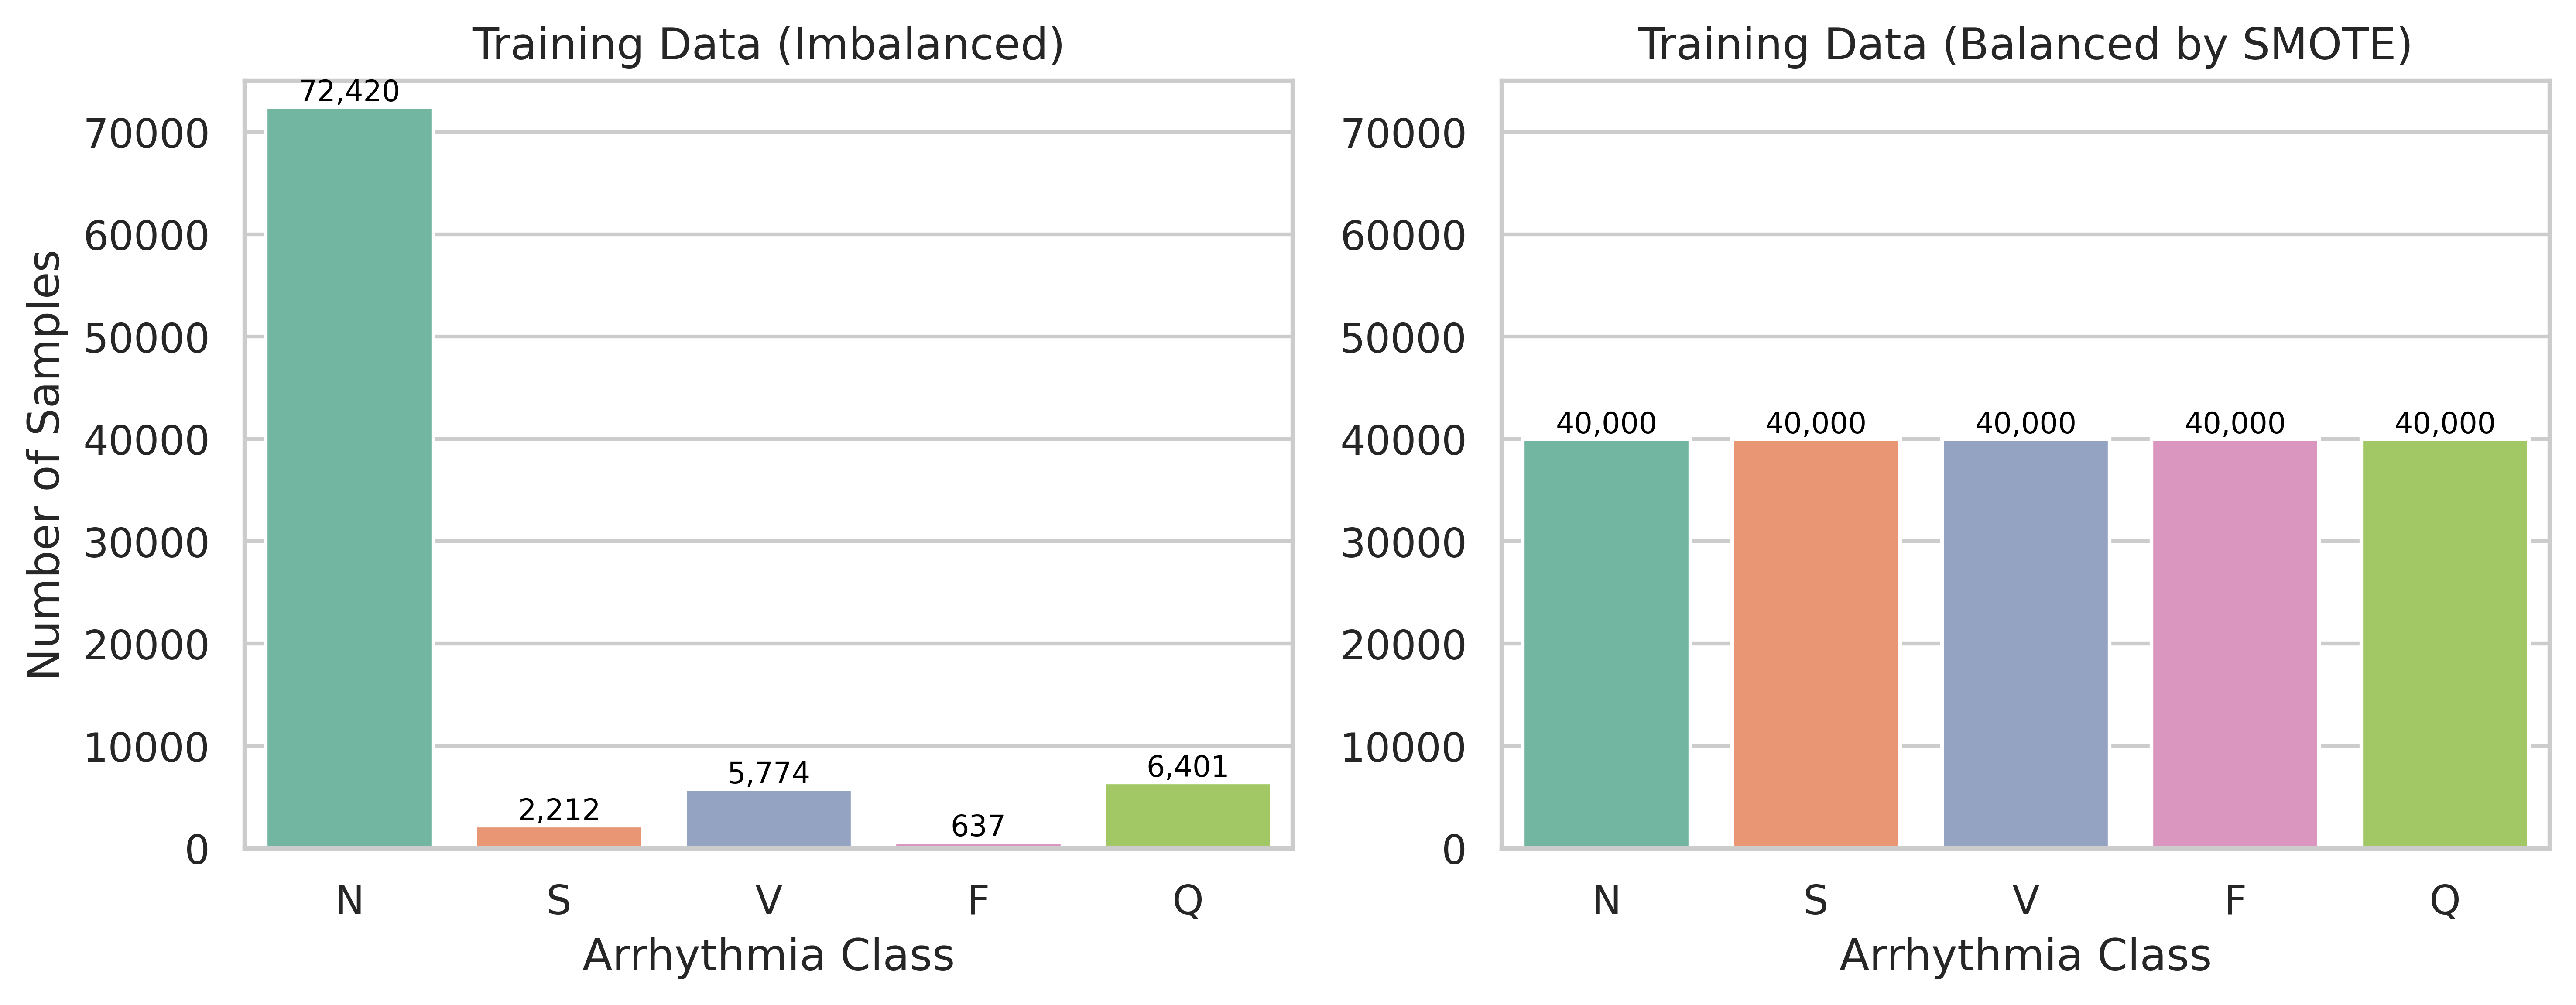

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Fixed color palette (5 consistent colors)
palette = sns.color_palette("Set2", 5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=600)

# --- Before balancing ---
sns.barplot(ax=axes[0], x=['N', 'S', 'V', 'F', 'Q'],
            y=[72420, 2212, 5774, 637, 6401],
            palette=palette)

axes[0].set_ylim(0, 75000)
axes[0].set_title("Training Data (Imbalanced)")
axes[0].set_xlabel("Arrhythmia Class")
axes[0].set_ylabel("Number of Samples")

# Annotate counts
for p in axes[0].patches:
    axes[0].annotate(format(int(p.get_height()), ','),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=8, color='black')

# --- After balancing ---
sns.barplot(ax=axes[1], x=['N', 'S', 'V', 'F', 'Q'],
            y=class_data.values,
            palette=palette)

axes[1].set_ylim(0, 75000)
axes[1].set_title("Training Data (Balanced by SMOTE)")
axes[1].set_xlabel("Arrhythmia Class")
axes[1].set_ylabel("")

# Annotate counts
for p in axes[1].patches:
    axes[1].annotate(format(int(p.get_height()), ','),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()

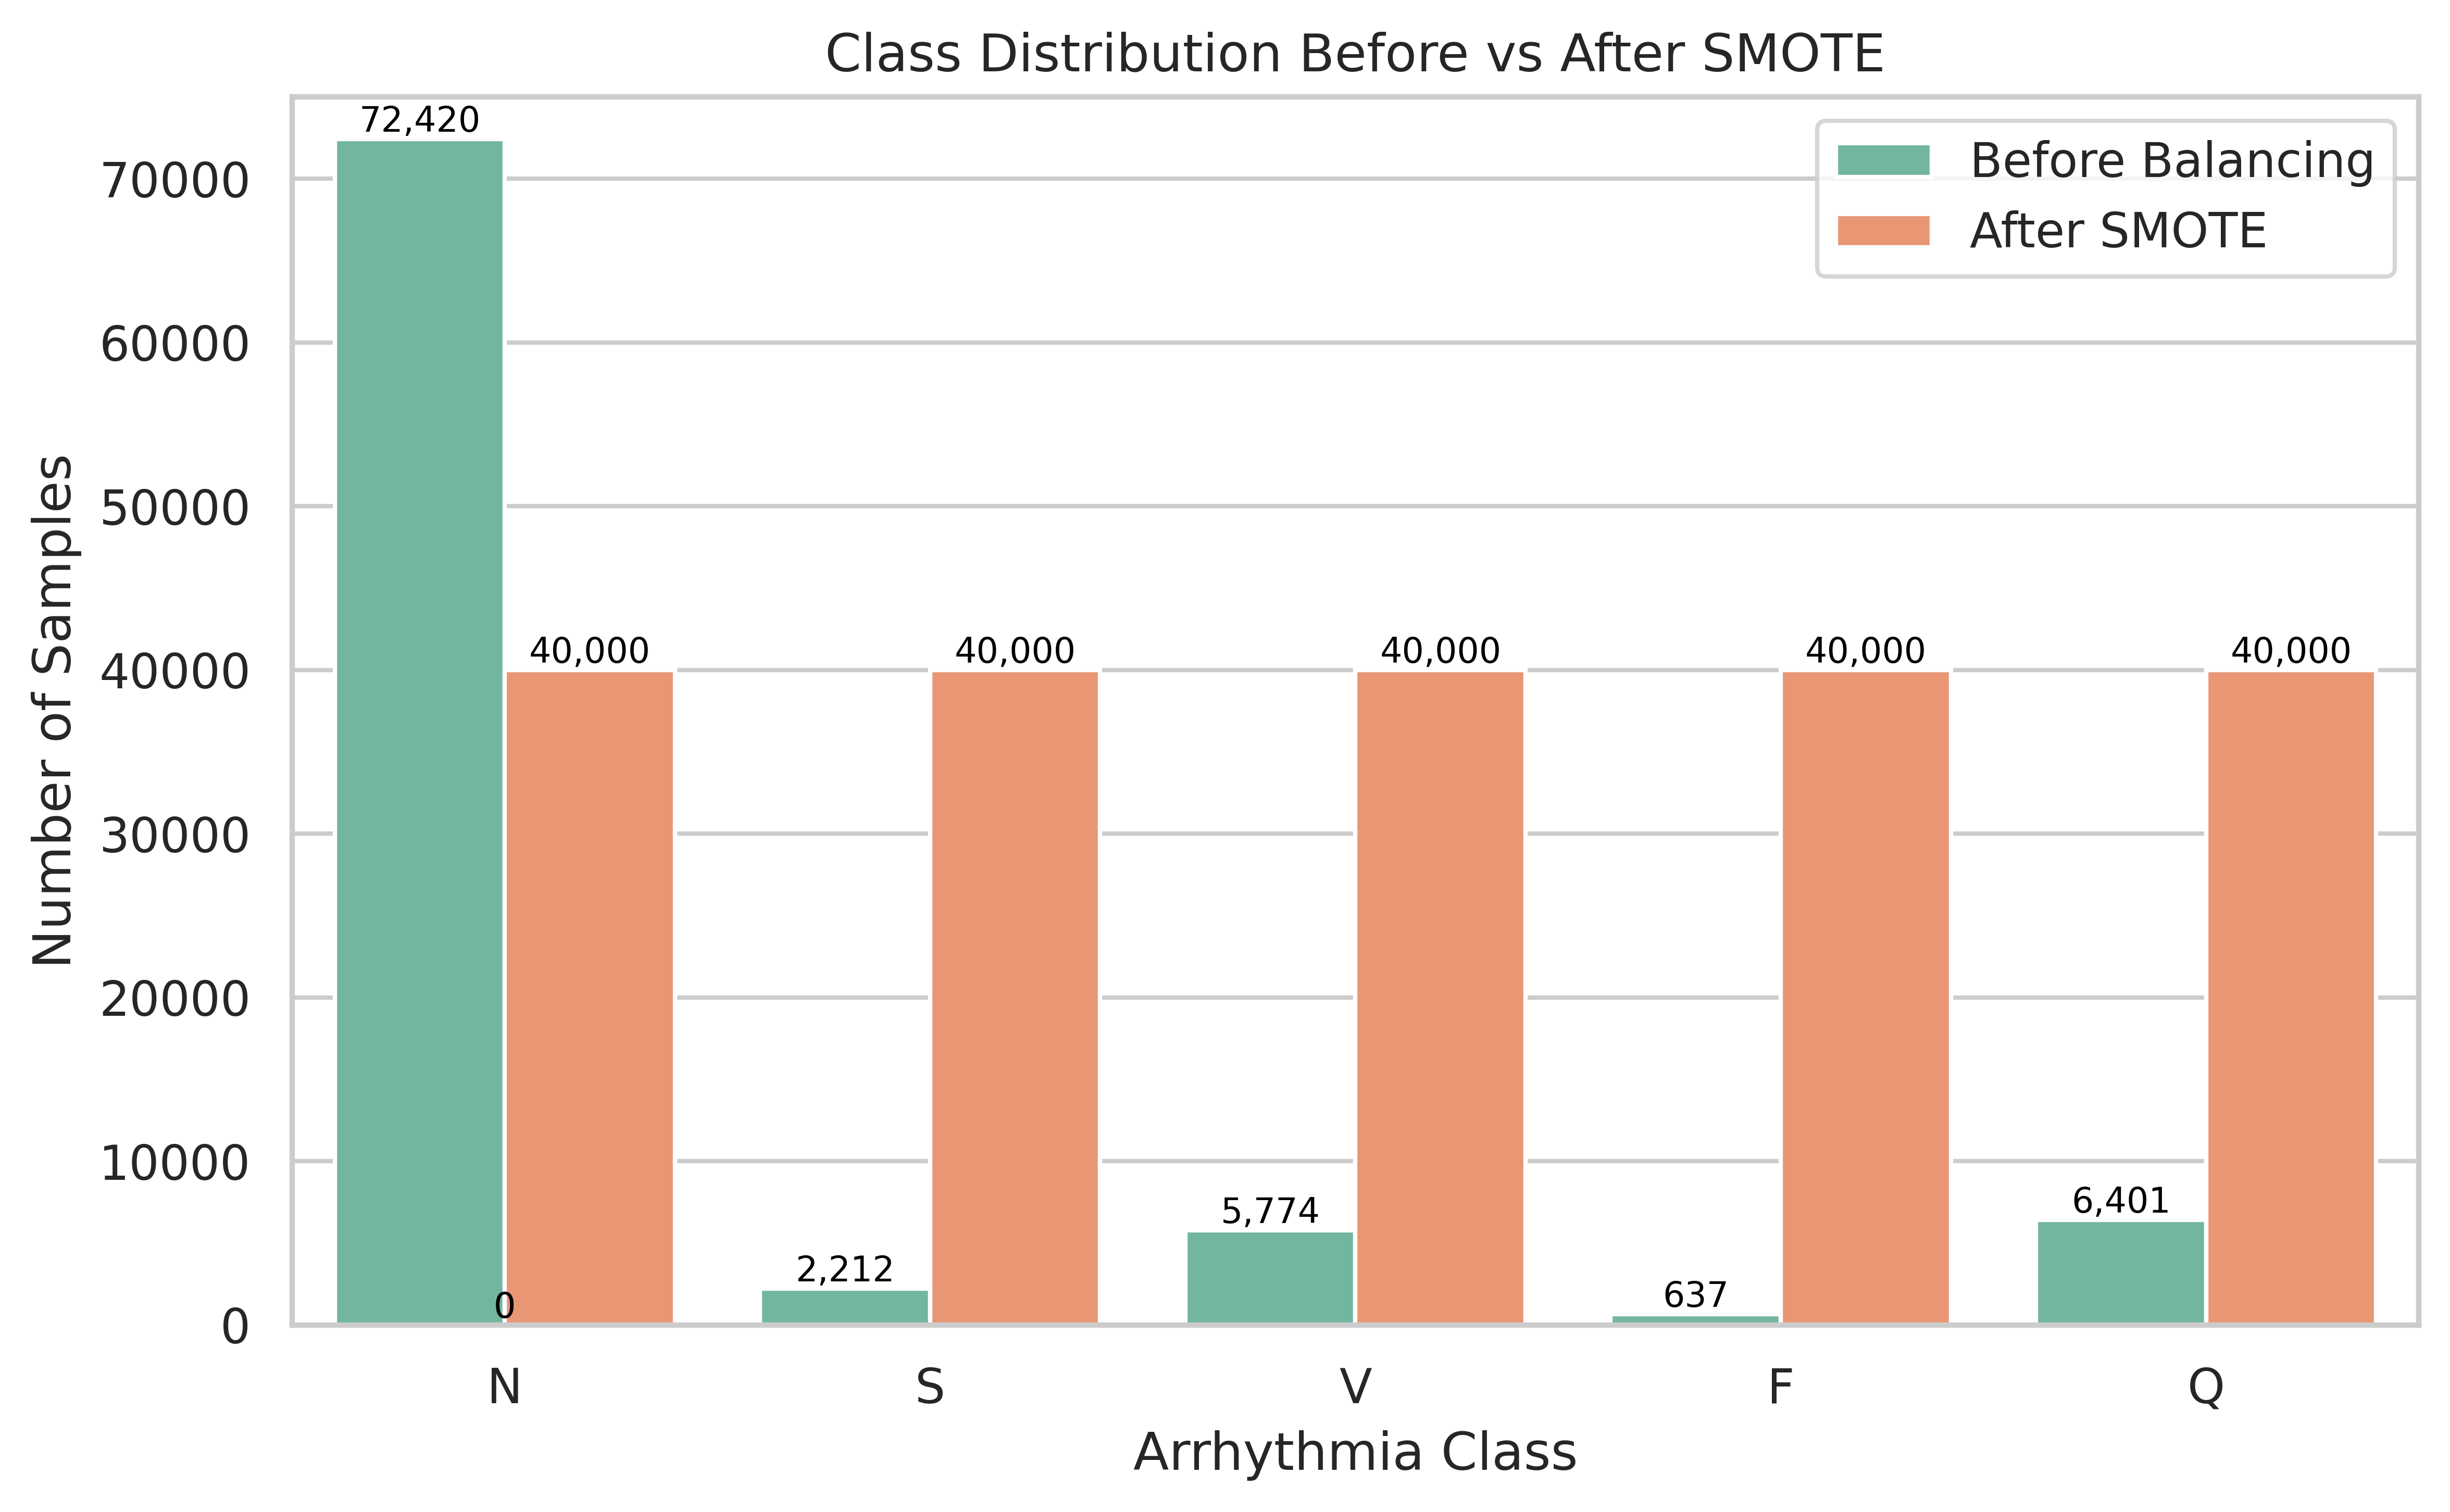

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Class names
classes = ['N', 'S', 'V', 'F', 'Q']

# Counts before balancing
counts_before = [72420, 2212, 5774, 637, 6401]

# Counts after balancing (from your class_data)
counts_after = class_data.values

# Build dataframe for plotting
df_plot = pd.DataFrame({
    "Class": classes * 2,
    "Samples": list(counts_before) + list(counts_after),
    "Dataset": ["Before Balancing"] * len(classes) + ["After SMOTE"] * len(classes)
})

# Plot grouped bars
plt.figure(figsize=(8, 5), dpi=600)
sns.barplot(data=df_plot, x="Class", y="Samples", hue="Dataset", palette="Set2")

plt.title("Class Distribution Before vs After SMOTE")
plt.xlabel("Arrhythmia Class")
plt.ylabel("Number of Samples")
plt.ylim(0, 75000)

# Annotate counts on bars
for p in plt.gca().patches:
    plt.gca().annotate(format(int(p.get_height()), ','),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=8, color='black')

plt.legend(title="")
plt.tight_layout()
plt.show()

# **Part E: Model Building and Training**
A **CNN-LSTM and attention** based hybrid model is formulated.

## **E1: Attention Mechanism**
**Convolutional Block Attention Module** ([CBAM](https://arxiv.org/abs/1807.06521)) consists two parts (i) **channel attention**, (ii) spatial attention. ECG is an 1D signal and 1-lead ECG is used in the modle.Therefore, only channel attention is only used.

In [14]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [15]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

## **E2: CNN-LSTM and attention model architecture**

### **a. Model building**

In [16]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **b. Hyperparameter Tuning**
Many architectures of model is found by changing hyperparameters.
* Model: with or without channel or spatial attention.
* CNN Filters: Number of filters in each Conv layer is changing like 4, 16, 32, 64, 128 etc.
* LSTM Units: Number of units of two LSTM layer is varing like 32, 64, 128 etc.

In [17]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

### **c. Model Training**

**Build, save and then Fit the Model.**
If we have already the saved model, then no need to build, save and fit again.

In [23]:
import datetime
import os

# Define project path
project_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/"

# Create logs folder if it doesn't exist
if not os.path.exists(project_path + "logs"):
    os.makedirs(project_path + "logs")

# TensorBoard log directory
logdir = project_path + "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Model path
model_path = project_path + "ecg_model_code17_t5.h5"

# Checkpoint for weights only
checkpoint_filepath = project_path + "ecg_model_code17_t5.weights.h5"

print("Logdir:", logdir)
print("Model path:", model_path)
print("Checkpoint path:", checkpoint_filepath)

Logdir: /content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/logs/20250912-120447
Model path: /content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/ecg_model_code17_t5.h5
Checkpoint path: /content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/ecg_model_code17_t5.weights.h5


In [24]:
# percentage of training data used for model validation
ratio = 0.2

In [28]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath=project_path + "code_17_t5_weights.hdf5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(X_train, Y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 300, 16)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 150, 32)        │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 75, 64)         │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 38, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 38, 128)        │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 38, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 38, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       311,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,797 (2.97 MB)

 Trainable params: 777,797 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/code_17_t5_weights.hdf5

In [12]:
import tensorflow as tf

def buildModel(input_shape=(300, 1), num_classes=5):
    # Input
    inputs = tf.keras.Input(shape=input_shape)

    # --- Conv block 1 ---
    x = tf.keras.layers.Conv1D(64, kernel_size=7, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelAttention(filters=64)(x)  # your Channel Attention layer

    # --- Conv block 2 ---
    x = tf.keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelAttention(filters=128)(x)

    # --- BiLSTM ---
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # --- Dense layers ---
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Model
    model = tf.keras.Model(inputs, outputs)
    return model


In [13]:
# Build the model
model = buildModel(input_shape=(300,1), num_classes=5)

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


NameError: name 'ChannelAttention' is not defined

In [11]:
import os
import tensorflow as tf

model_path = "/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/CNN_ecg_model"
if os.path.exists(model_path):
    # Import the trained model
    print('Model already exists at the filepath')
    model = tf.keras.models.load_model(model_path)
else:
    # Build a CNN model
    print('Model not found, now building and saving...')
    model = buildModel()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # Callbacks
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=1
    )

    # ModelCheckpoint (save weights only)
    checkpoint_filepath = os.path.join(project_path, "code_17_t5.weights.h5")  # ✅ ends with .weights.h5
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    callback_list = [tensorboard_callback, model_checkpoint_callback]

    # Training
    history = model.fit(
        X_train, Y_train,
        epochs=30,
        batch_size=128,
        validation_split=ratio,
        callbacks=callback_list
    )

    # Save full model (architecture + weights)
    model.save(model_path)

Model not found, now building and saving...


NameError: name 'buildModel' is not defined

In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# -------------------------
# User data assumed available:
# X (N, 300)  - raw segments
# Y (N,)      - integer labels 0..14
# -------------------------

# --- 1) Basic safety & shapes ---
X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.int32)

# Trim to same length if mismatch (safe-guard)
min_len = min(len(X), len(Y))
if len(X) != len(Y):
    X = X[:min_len]
    Y = Y[:min_len]

# Train/val/test split:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.1, random_state=42, stratify=Y_train_full
)

# Add channel dim for Conv1D
X_train = X_train.reshape((-1, 300, 1))
X_val   = X_val.reshape((-1, 300, 1))
X_test  = X_test.reshape((-1, 300, 1))

print("Shapes ->", X_train.shape, X_val.shape, X_test.shape, Y_train.shape)

# --- 2) Class weights to handle imbalance ---
classes = np.unique(Y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight)

# --- 3) Data augmentation (tf.data) ---
AUTOTUNE = tf.data.AUTOTUNE
def augment_fn(x, y):
    # x: (300,1)
    x = tf.cast(x, tf.float32)

    # Random scaling
    if tf.random.uniform(()) < 0.5:
        scale = tf.random.uniform((), 0.9, 1.1)
        x = x * scale

    # Random noise (relative to max amplitude)
    if tf.random.uniform(()) < 0.5:
        std = 0.01 * tf.math.reduce_max(tf.abs(x))
        x = x + tf.random.normal(tf.shape(x), mean=0.0, stddev=std)

    # Random time shift
    if tf.random.uniform(()) < 0.5:
        shift = tf.random.uniform((), -10, 10, dtype=tf.int32)
        x = tf.roll(x, shift, axis=0)

    return x, y

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = (train_ds.shuffle(20000)
            .map(augment_fn, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).prefetch(AUTOTUNE)

# -------------------------
# 4) Model: ResNet1D with SE blocks
# -------------------------
def se_block(input_tensor, reduction=8):
    filters = int(input_tensor.shape[-1])
    se = tf.keras.layers.GlobalAveragePooling1D()(input_tensor)               # (B, filters)
    se = tf.keras.layers.Dense(filters // reduction, activation='relu')(se)  # (B, f/reduction)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)            # (B, filters)
    se = tf.keras.layers.Reshape((1, filters))(se)                           # (B,1,filters)
    return tf.keras.layers.Multiply()([input_tensor, se])

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = tf.keras.layers.Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Squeeze-and-Excitation
    x = se_block(x, reduction=8)

    # adjust shortcut if channels or stride differ
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv1D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_resnet1d(input_shape=(300,1), num_classes=15):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # Stage 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Stage 2
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    # Stage 3
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    # optional Stage 4 (uncomment to deepen)
    # x = residual_block(x, 512, stride=2)
    # x = residual_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# -------------------------
# 5) Compile
# -------------------------
num_classes = len(np.unique(Y))
model = build_resnet1d(input_shape=(300,1), num_classes=num_classes)
model.summary()

# try to use AdamW if available, else regular Adam
try:
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-3, weight_decay=1e-5)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# -------------------------
# 6) Callbacks
# -------------------------
project_path = '/content/drive/MyDrive/PhD Dataset/mit-bih-arrhythmia-database-1.0.0/'
logdir = os.path.join(project_path, "logs_resnet1d")
os.makedirs(logdir, exist_ok=True)
model_path = os.path.join(project_path, "best_resnet1d.keras")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=logdir)
]

# -------------------------
# 7) Train
# -------------------------
epochs = 60  # start here; consider 100 with good callbacks
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# -------------------------
# 8) Evaluate on test set
# -------------------------
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size).prefetch(AUTOTUNE)
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc, "Test Loss:", test_loss)

NameError: name 'X' is not defined

### **d. Plotting Accuracy and Loss**
Training and Validation accuray and loss curve plotting.

In [ ]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.xlabel("Epochs")       # ✅ X-label
plt.ylabel("Accuracy")     # ✅ Y-label
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.xlabel("Epochs")       # ✅ X-label
plt.ylabel("Loss")         # ✅ Y-label
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/gdrive/MyDrive/ECG Arrhythmia trying/mit-bih-arrhythmia-database-1.0.0/logs\20221220-113542'

# **Part F: Results**


## **F1: Classification Accuracy and Confusion Matrix**
The overall classification accuracy and confusion matrix generated by the follwoing code.

**Model Testing**
* a. Using **recently trained** and Saved Model after 30 Epochs.
* b. Using the **best model** saved by *'model checkpoint'* callback.

**a. Using Recently Trained Model**

In [ ]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

**b. Using the Best Model**
We saved many checkpoints of the model. Among these checkpoints we will consider the checkpoint which has the largest validation accuracy. Then copy its path and update the model weights.

In [ ]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

In [ ]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(X_train, Y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(X_test, Y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

**Confusion Matrix**

In [147]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [148]:
# predict
Y_pred = np.argmax(model.predict(X_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(Y_test, Y_pred)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


NameError: name 'Y_test' is not defined

## **F2: Per Class Performance**
Calculating per class Sensitivity, Specificity, Accuracy and F1 score.

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

**a. Recently Trained Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

**b. Best Model**

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model2.predict(X_test), axis=-1)
multi_classification_report(Y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)